# *Solusi Tim Suika untuk Task 1 Seleksi Internal Gemastik*

---
* *Vincent Davis Leonard Tjoeng* – 2306275014
* *Rahardi Salim* – 2306201861
* *Christian Yudistira Hermawan* – 2306241676
---

# Human Activity Recognition using Sensor Data
*Klasifikasi Aktivitas Manusia menggunakan Data Akselerometer dan Giroskop*

## Table of Contents
1. [Overview](#overview)
2. [Dataset Description](#dataset-description)
3. [Library Imports & Setup](#library-imports--setup)
4. [Data Loading & Initial Exploration](#data-loading--initial-exploration)
5. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
6. [Data Preprocessing](#data-preprocessing)
7. [Feature Engineering](#feature-engineering)
8. [Model Development](#model-development)
9. [Model Evaluation](#model-evaluation)
10. [Prediction & Submission](#prediction--submission)
11. [Conclusions](#conclusions)
12. [Adisi, Eksperimen & Lain Lain](#adisi)
13. [Sumber](#sumber)

## Overview

**Human Activity Recognition (HAR)** menggunakan data sensor merupakan komponen kunci dalam banyak aplikasi dunia nyata, termasuk:
- **Pemantauan kesehatan** (deteksi jatuh)
- **Pelacakan olahraga dan kebugaran**
- **Desain animasi dan gerakan**
- **Interaksi manusia-robot**

Dalam proyek ini, kita bekerja dengan dataset time series gerakan manusia yang diambil melalui sensor simulasi (**akselerometer** dan **giroskop**) untuk mengklasifikasikan berbagai aktivitas fisik.

### Target Classes:
- **Arm Waving**: 0
- **Jumping**: 1  
- **Sports Action**: 2
- **Walking**: 3

### Evaluation Metric:
**F1-Score (Macro)** - menilai kualitas model dalam memprediksi keempat jenis aktivitas fisik.

## Dataset Description

Dataset terdiri dari pembacaan sensor yang telah dibersihkan dan dipisahkan ke dalam file:
- `train.csv` - Data training dengan label
- `validation.csv` - Data validasi dengan label  
- `test.csv` - Data test tanpa label

### Kolom Dataset:
| Kolom | Deskripsi |
|-------|-----------|
| **ID** | Pengenal unik (sesi atau individu) |
| **Accel_X/Y/Z** | Pembacaan akselerometer di sepanjang 3 sumbu |
| **Gyro_X/Y/Z** | Pembacaan giroskop di sepanjang 3 sumbu |
| **Timestamp** | Stempel waktu Unix (dalam detik, dikelompokkan dalam blok) |
| **Activity_Type** | Label target (hanya pada train/validation) |

### Catatan Penting:
- **Setiap Timestamp** berhubungan dengan **sensor yang berbeda**
- Beberapa timestamp memiliki **missing data** (biasanya 10 sample per timestep, tapi bisa kurang)
- Prediksi dilakukan **per ID** (satu baris untuk satu ID)

## Library Imports & Setup

In [1]:
# Core Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary
from tqdm import tqdm

# Data Analysis & Visualization
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis

# Utilities
import random
import os

# Set Random Seeds for Reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# Device Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


Penting untuk mengatur random seeds (`seed_value = 42`) untuk reprodusibilitas. Ini memastikan bahwa setiap kali kode dijalankan, hasil yang berhubungan dengan keacakan (misalnya, pembagian data atau inisialisasi model) akan konsisten. Pemilihan perangkat (device) ke `cpu` atau `cuda` (GPU) juga dilakukan untuk mengoptimalkan komputasi jika GPU tersedia.

## Data Loading & Initial Exploration

Dataset dibagi menjadi tiga bagian: `train.csv`, `validation.csv`, dan `test.csv`.

- `train.csv`: Data pelatihan dengan label aktivitas.

- `validation.csv`: Data validasi dengan label, digunakan untuk tuning model dan evaluasi performa selama pengembangan.

- `test.csv`: Data uji tanpa label, digunakan untuk membuat prediksi akhir yang akan disubmit.

In [2]:
# Load datasets
train = pd.read_csv('/kaggle/input/gemas-dan-menggelitik/train.csv')
valid = pd.read_csv('/kaggle/input/gemas-dan-menggelitik/validation.csv')
test = pd.read_csv('/kaggle/input/gemas-dan-menggelitik/test.csv')

print("Dataset shapes:")
print(f"Training set: {train.shape}")
print(f"Validation set: {valid.shape}")
print(f"Test set: {test.shape}")

Dataset shapes:
Training set: (31608, 9)
Validation set: (5974, 9)
Test set: (11943, 8)


Output dari kode ini mengonfirmasi ukuran masing-masing dataset:

- Training set: (31608, 9)

- Validation set: (5974, 9)

- Test set: (11943, 8)

Ini menunjukkan bahwa dataset test memiliki satu kolom lebih sedikit (`Activity_Type`), yang memang sudah semestinya karena itu adalah kolom target yang harus kita prediksi.

Selanjutnya, kita melakukan pemeriksaan awal terhadap tipe data dan keberadaan nilai yang hilang (missing values) serta duplikasi.

### Data Types & Missing Values:

In [3]:
# Check data info
train.info()

# Check for duplicates and missing values
print('Duplicates in train =', sum(train.duplicated()))
print('Duplicates in test =', sum(test.duplicated()))
print('Duplicates in valid =', sum(valid.duplicated()))
print('Invalid values in train =', train.isnull().values.sum())
print('Invalid values in test =', test.isnull().values.sum())
print('Invalid values in valid =', valid.isnull().values.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31608 entries, 0 to 31607
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             31608 non-null  int64  
 1   Accel_X        31608 non-null  float64
 2   Accel_Y        31608 non-null  float64
 3   Accel_Z        31608 non-null  float64
 4   Gyro_X         31608 non-null  float64
 5   Gyro_Y         31608 non-null  float64
 6   Gyro_Z         31608 non-null  float64
 7   Timestamp      31608 non-null  int64  
 8   Activity_Type  31608 non-null  object 
dtypes: float64(6), int64(2), object(1)
memory usage: 2.2+ MB
Duplicates in train = 0
Duplicates in test = 0
Duplicates in valid = 0
Invalid values in train = 0
Invalid values in test = 0
Invalid values in valid = 0


Hasil pemeriksaan ini sangat menggembirakan: `tidak ada duplikasi` dan `tidak ada nilai yang hilang` di ketiga dataset. Ini berarti data sudah bersih dan siap untuk eksplorasi lebih lanjut.

Perlu dicatat juga bahwa secara default diketahui dari deskripsi data bahwa sekuensi tiap `Timestamp` biasanya memiliki panjang data 10 row, namun ada beberapa `Timestamp` yang tidak berjumlah demikian. Ini akan menjadi pertimbangan lanjutan di seleksi data nanti.

Pemeriksaan overlap `Timestamp` antar dataset juga dilakukan. Timestamp ini merepresentasikan blok atau jendela pengukuran sensor.

In [4]:
# Cek overlap Timestamp antar split
train_timestamps = set(train['Timestamp'])
test_timestamps = set(test['Timestamp'])
valid_timestamps = set(valid['Timestamp'])

# Periksa irisan Timestamp antar pasangan
overlap_train_test = train_timestamps.intersection(test_timestamps)
overlap_train_valid = train_timestamps.intersection(valid_timestamps)
overlap_test_valid = test_timestamps.intersection(valid_timestamps)

print(f"Overlap train-test: {len(overlap_train_test)}")
print(f"Overlap train-valid: {len(overlap_train_valid)}")
print(f"Overlap test-valid: {len(overlap_test_valid)}")
print(overlap_train_valid )

Overlap train-test: 0
Overlap train-valid: 1
Overlap test-valid: 0
{1728017077}


Hasil menunjukkan bahwa **tidak ada Timestamp yang tumpang tindih** antar set data (train, valid, test). Ini adalah temuan krusial yang akan memengaruhi bagaimana kita memperlakukan fitur Timestamp di tahap feature engineering. Jika ada tumpang tindih, model bisa "menghafal" pola berdasarkan Timestamp tertentu, bukan gerakan sebenarnya. Dengan tidak adanya tumpang tindih, kita perlu strategi yang berbeda untuk memanfaatkan informasi waktu.

Berdasarkan deskripsi data, perbedaan kolom ini juga menandakan **penggunaan alat ukur di lokasi yang berbeda** yang lokasinya tidak diketahui.

## Exploratory Data Analysis (EDA)

### 1. Target Distribution Analysis

Langkah pertama adalah melihat bagaimana aktivitas (`Activity_Type`) terdistribusi dalam dataset pelatihan.

Distribution of Activity Types in Training Set:
Activity_Type
Walking          8046
Jumping          8043
Arm Waving       7760
Sports Action    7759
Name: count, dtype: int64


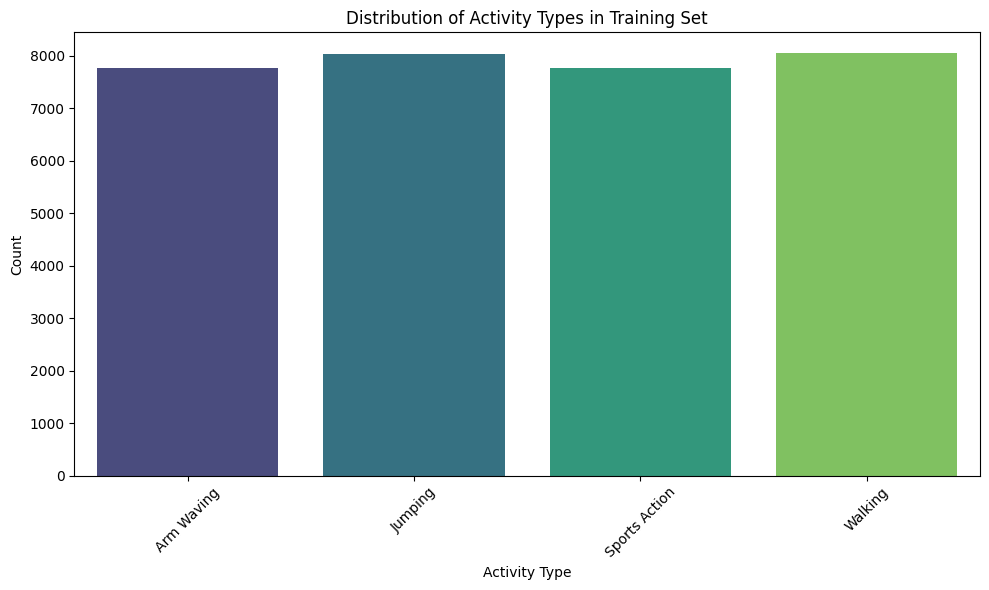

In [5]:
print("Distribution of Activity Types in Training Set:")
activity_counts = train['Activity_Type'].value_counts()
print(activity_counts)

# Visualize target distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='Activity_Type', palette='viridis')
plt.title('Distribution of Activity Types in Training Set')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Hasilnya menunjukkan distribusi yang relatif seimbang antar keempat kelas:

- Walking: ~25.4%

- Jumping: ~25.4%

- Arm Waving: ~24.5%

- Sports Action: ~24.5%

Ini merupakan insight yang cukup menarik. Dataset yang seimbang meminimalkan risiko model bias terhadap kelas mayoritas dan memastikan bahwa metrik evaluasi seperti akurasi lebih dapat diandalkan. Ini juga memperkuat penggunaan F1-Score (Macro) sebagai metrik, karena metrik ini memperhitungkan performa di setiap kelas secara setara.

### 2. User (ID) Distribution Analysis

Memahami bagaimana data tersebar di antara ID pengguna adalah penting. Apakah beberapa pengguna memiliki lebih banyak data atau hanya melakukan aktivitas tertentu?

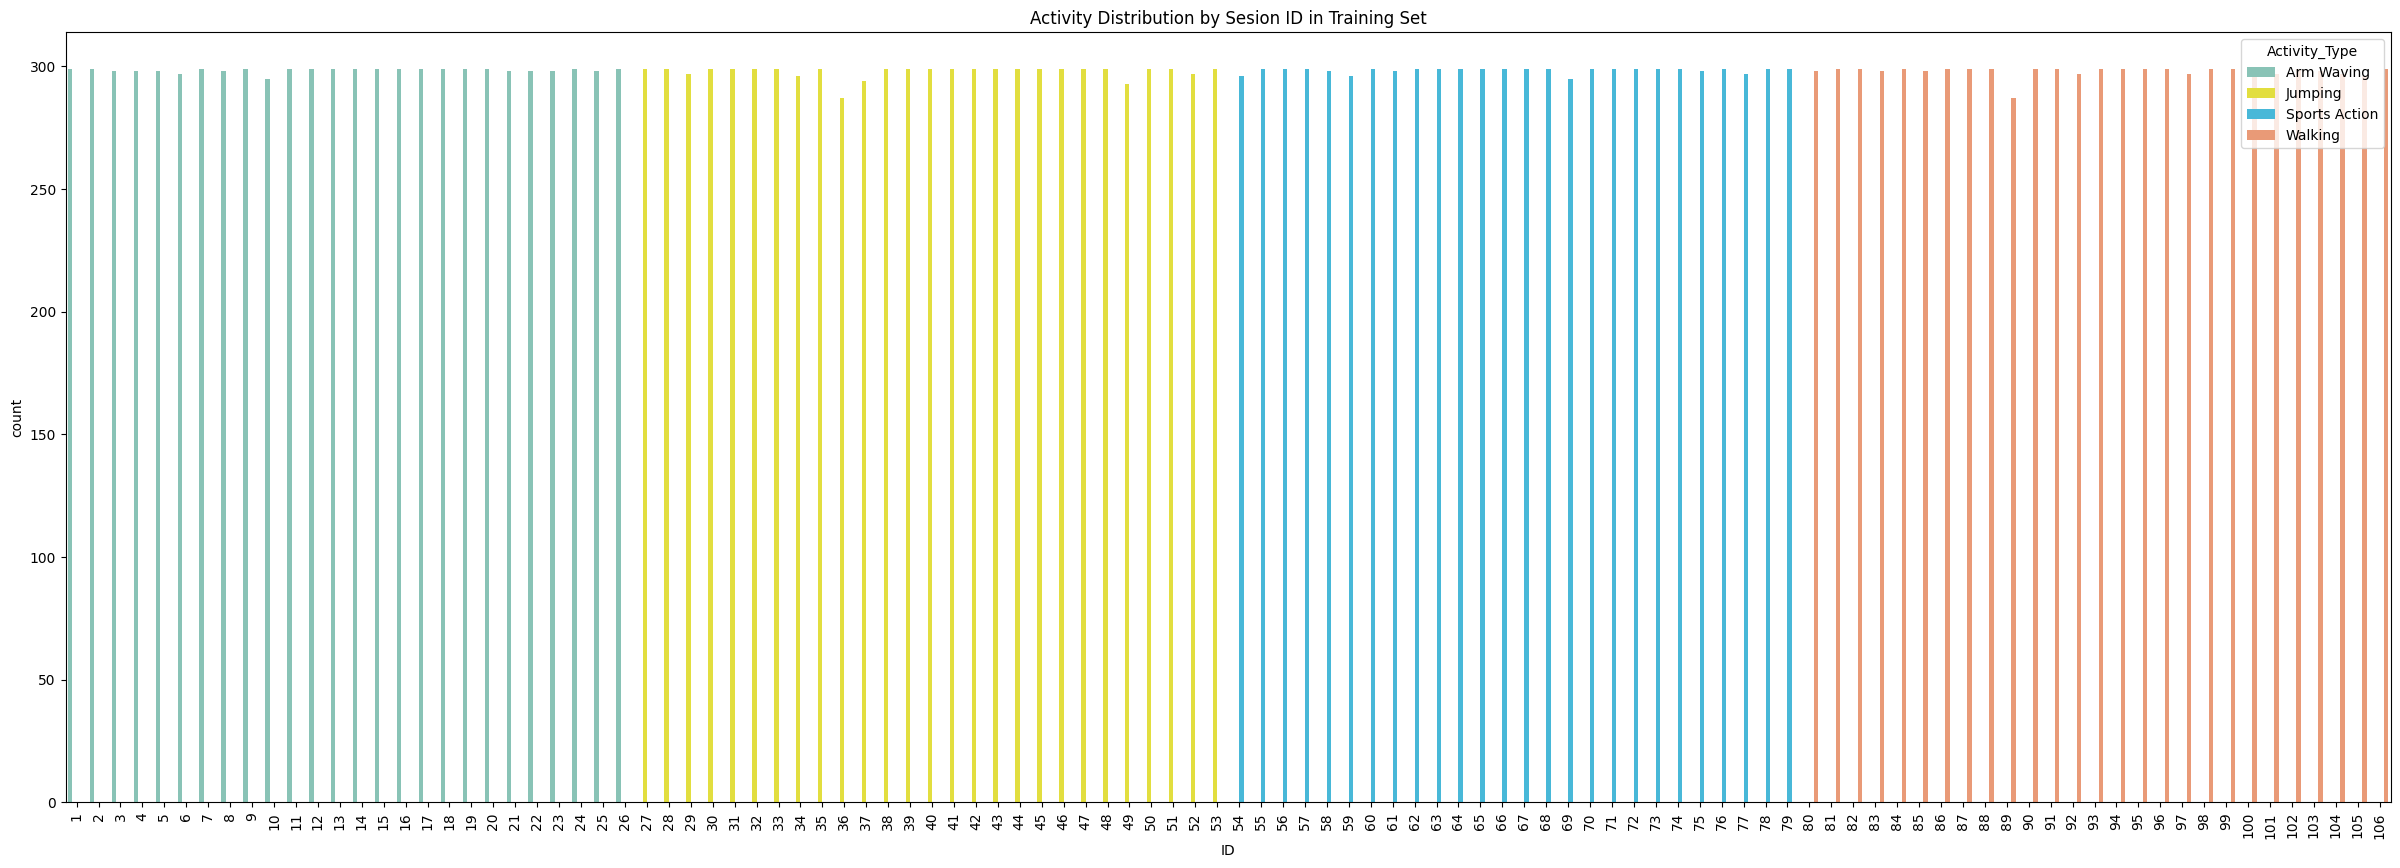

Samples per Sesion ID in Training:
Average samples per user: 298.2
Min samples: 287
Max samples: 299


In [6]:
# Analyze distribution per user ID
plt.figure(figsize=(30,10))
sns.countplot(x='ID', hue='Activity_Type', 
              palette=["#7fcdbb","#fdf824","#30c6f0","#fc9264"], 
              data=train)
plt.title('Activity Distribution by Sesion ID in Training Set')
plt.xticks(rotation=90)
plt.show()

# Check samples per user
print("Samples per Sesion ID in Training:")
user_counts = train['ID'].value_counts()
print(f"Average samples per user: {user_counts.mean():.1f}")
print(f"Min samples: {user_counts.min()}")
print(f"Max samples: {user_counts.max()}")

Visualisasi `countplot` menunjukkan bahwa ada **106 sesi unik** dalam training set, dan sebagian besar dari mereka memiliki representasi aktivitas yang seimbang. Rata-rata, ada sekitar 298 sampel per sesi, dengan rentang yang sangat ketat (287-299 sampel). Ini mengindikasikan bahwa data dikumpulkan secara konsisten di antara pengguna, yang membantu model untuk tidak terlalu overfit pada karakteristik individu pengguna tertentu.


### 3. Sensor Data Distribution Analysis

Sekarang, kita melihat distribusi nilai-nilai dari sensor akselerometer (`Accel_X/Y/Z`) dan giroskop (`Gyro_X/Y/Z`)

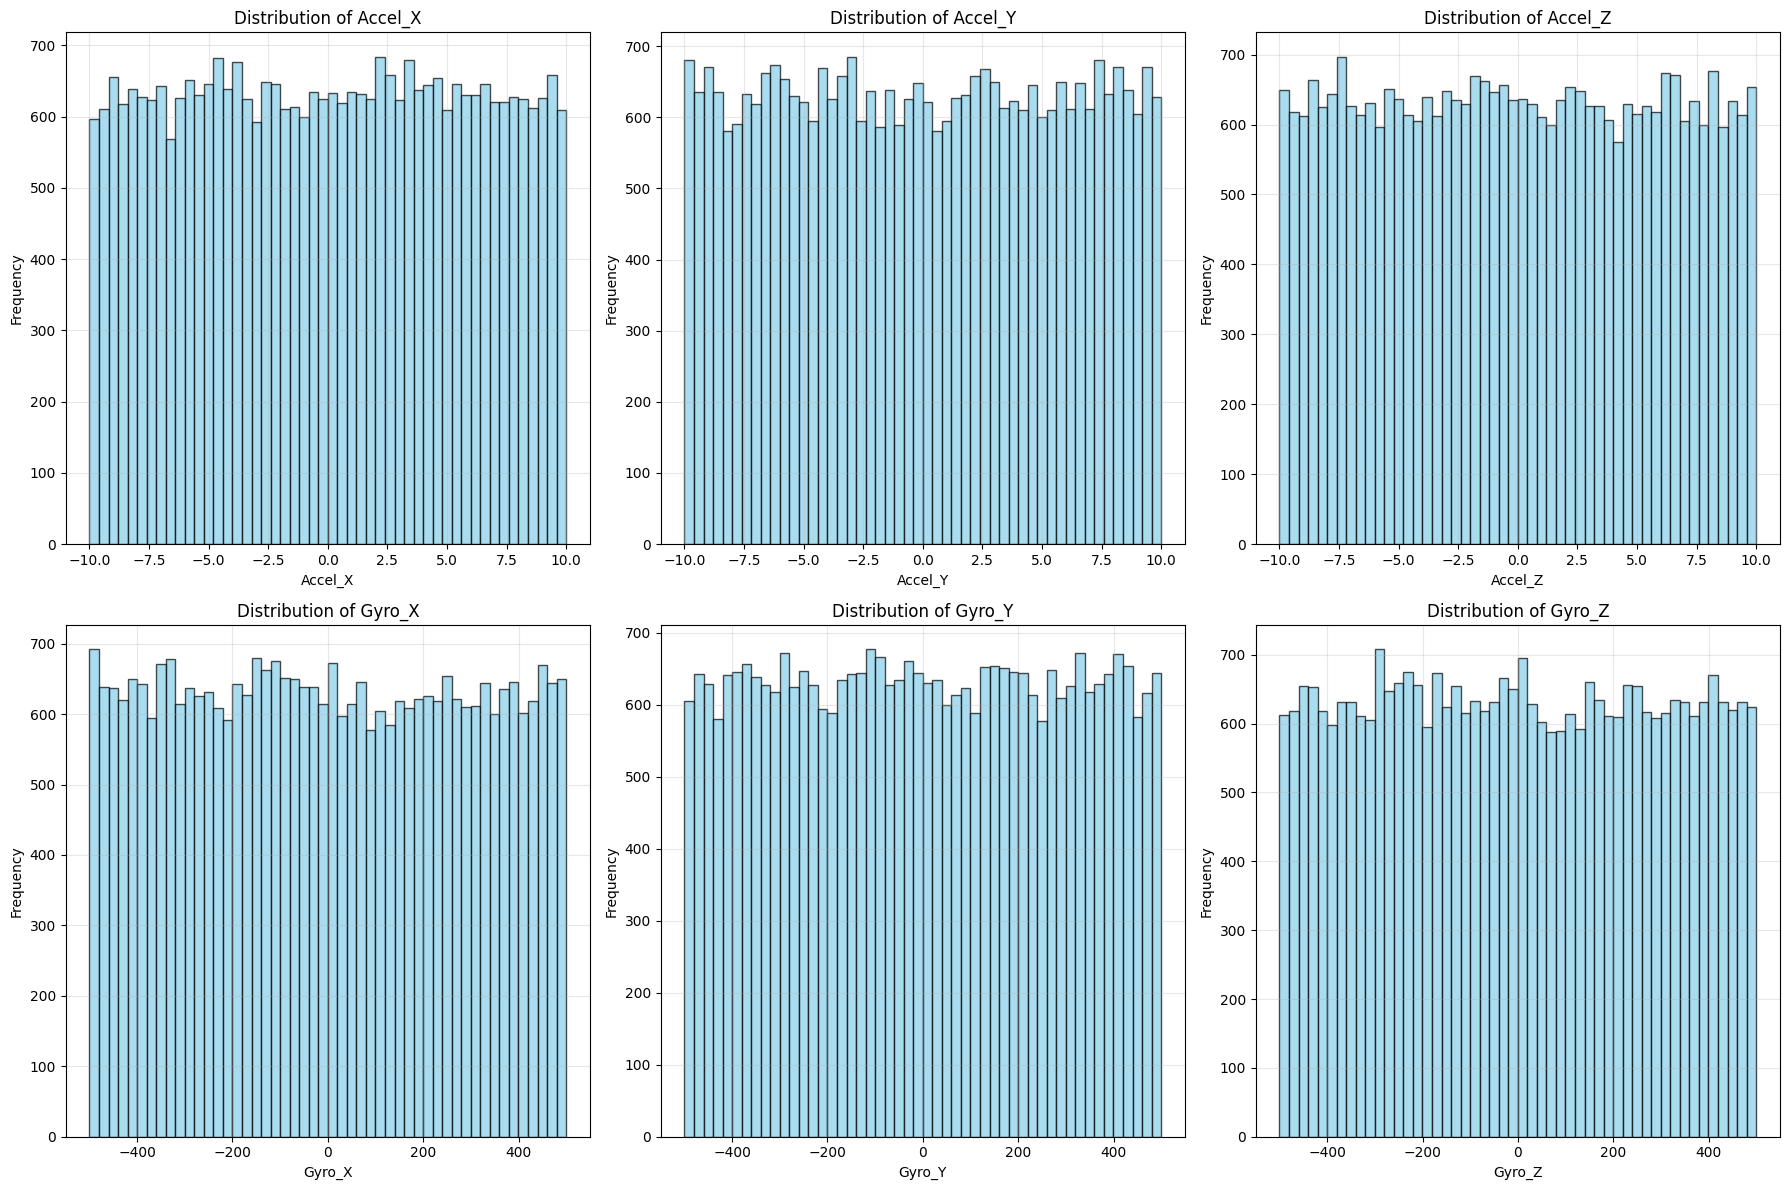

In [7]:
# Analyze sensor readings distribution
sensor_cols = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(sensor_cols):
    axes[i].hist(train[col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Histogram menunjukkan distribusi nilai-nilai sensor. Kebanyakan distribusi tampak **terpusat di sekitar nol dan tersebar di rentang yang sama**, yang wajar untuk pembacaan sensor yang mengukur perubahan atau deviasi dari keadaan diam. Beberapa sumbu mungkin menunjukkan skewness, yang bisa menjadi informasi berguna untuk feature engineering (misalnya, membuat fitur skewness atau kurtosis), meskipun dalam kasus ini, kita akan mengandalkan fitur turunan lainnya.

### 4. Activity-wise Sensor Analysis

Ini adalah salah satu bagian EDA yang paling informatif, tahap ini akan menjawab bagaimana nilai sensor berbeda untuk setiap jenis aktivitas?

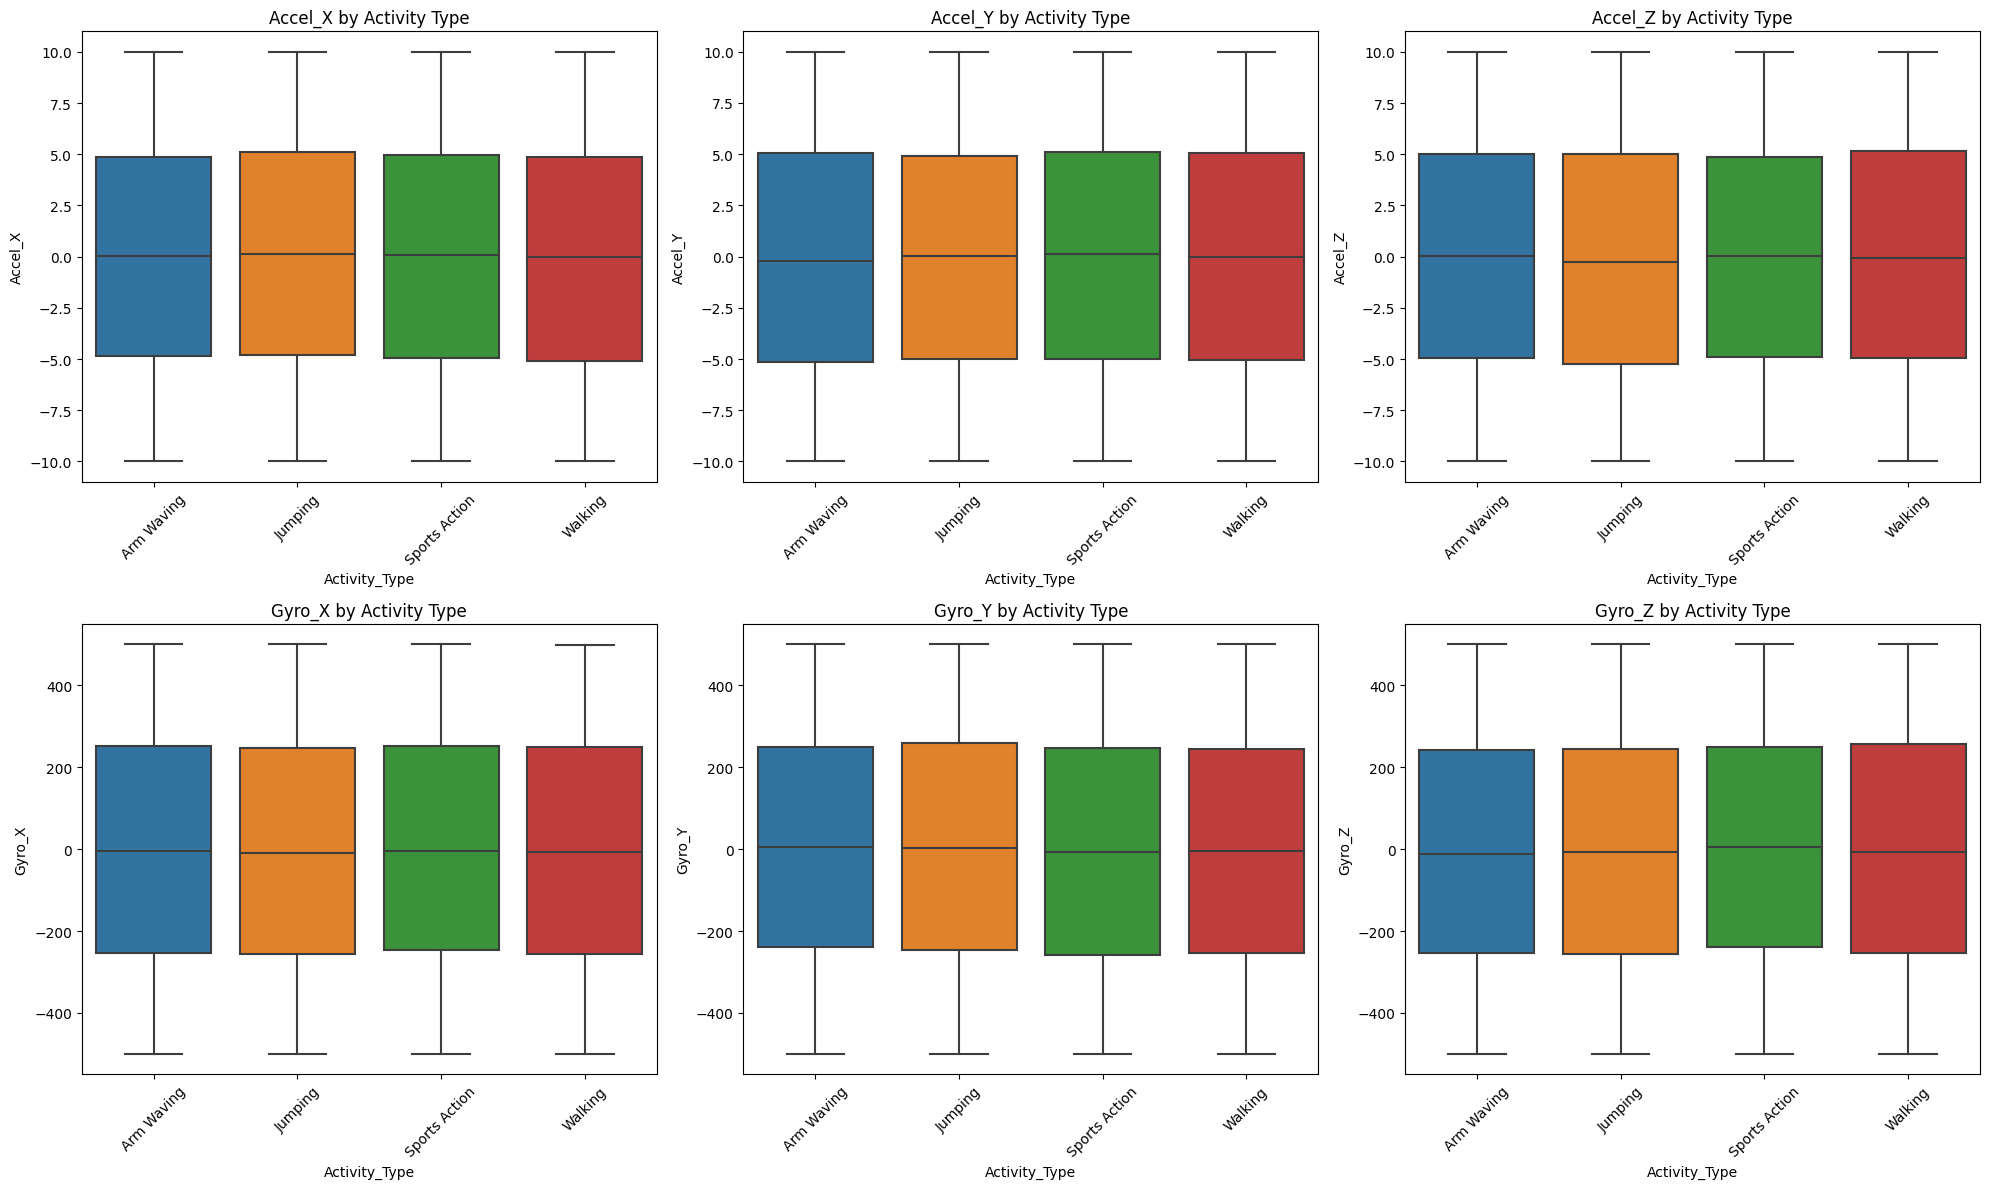

In [8]:
# Box plots for each sensor by activity type
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(sensor_cols):
    sns.boxplot(data=train, x='Activity_Type', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Activity Type')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Box plot menunjukkan bahwa nilai akselerometer dan giroskop pada sumbu X, Y, dan Z **memiliki median yang mirip** dan rentang yang tumpang tindih di antara aktivitas "Arm Waving", "Jumping", "Sports Action", dan "Walking". Hal ini sangatlah wajar dan ini mengindikasikan bahwa nilai sensor instan tunggal tidak cukup untuk membedakan aktivitas secara jelas. Perbedaan yang lebih signifikan kemungkinan terletak pada pola time series, seperti variabilitas, tingkat perubahan (jerk), atau fitur agregat dalam jendela waktu (misalnya, rolling mean atau standard deviation).

### 5. Correlation Analysis

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


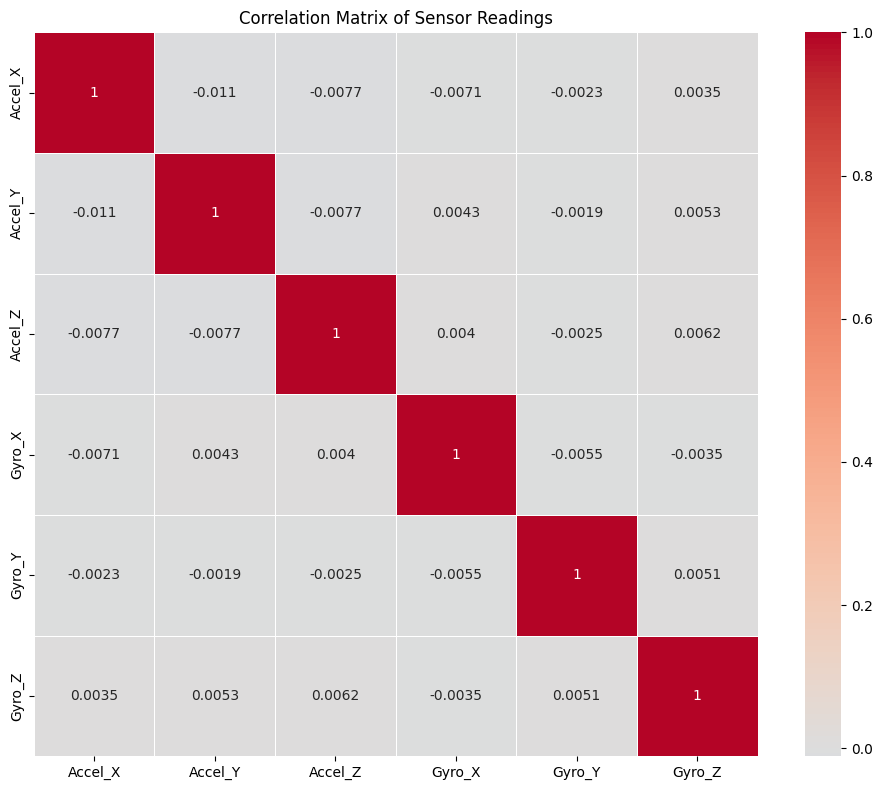

In [9]:
# Correlation matrix for sensor data
plt.figure(figsize=(10, 8))
correlation_matrix = train[sensor_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Sensor Readings')
plt.tight_layout()
plt.show()

Heatmap matriks korelasi akan menunjukkan seberapa kuat hubungan linear antar pembacaan sensor. Dari heatmap ini terlihat tidak ada korelasi yang kuat antar fitur. Namun, penting untuk dicatat bahwa **sensor gerak seringkali memiliki korelasi kompleks yang bersifat non-linear**, dan model tree-based seperti XGBoost mampu menangani ini dengan baik tanpa perlu menghilangkan fitur yang berkorelasi tinggi secara agresif.

### 6. Timestamp Analysis

Bagian EDA yang paling mendalam adalah menganalisis pola sensor dari waktu ke waktu untuk aktivitas dan ID tertentu. Ini memberikan gambaran visual tentang bagaimana sinyal sensor berubah selama aktivitas.

In [10]:
# Analyze timestamp patterns
print("Unique timestamps in training:", train['Timestamp'].nunique())
print("Unique timestamps in validation:", valid['Timestamp'].nunique())
print("Unique timestamps in test:", test['Timestamp'].nunique())

# Check timestamp overlap between datasets
train_timestamps = set(train['Timestamp'].unique())
valid_timestamps = set(valid['Timestamp'].unique())
test_timestamps = set(test['Timestamp'].unique())

print(f"Timestamp overlap (train-valid): {len(train_timestamps & valid_timestamps)}")
print(f"Timestamp overlap (train-test): {len(train_timestamps & test_timestamps)}")
print(f"Timestamp overlap (valid-test): {len(valid_timestamps & test_timestamps)}")

Unique timestamps in training: 3187
Unique timestamps in validation: 602
Unique timestamps in test: 1203
Timestamp overlap (train-valid): 1
Timestamp overlap (train-test): 0
Timestamp overlap (valid-test): 0


Fungsi `analyze_activity_patterns_by_id` dibuat untuk memvisualisasikan sinyal sensor yang dinormalisasi dan difilter untuk aktivitas tertentu, memilih beberapa ID pengguna teratas.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter

def analyze_activity_patterns_by_id(df, activity_to_compare, sample_ids=3, filter_type='median', 
                                    window_size=11, butter_order=3, butter_cutoff=0.1):

    print("="*60)
    print(f"ANALYSIS: Comparing '{activity_to_compare}' (Filter: {filter_type.title()})")
    print("="*60)

    activity_df = df[df['Activity_Type'] == activity_to_compare]
    if activity_df.empty:
        print(f" Warning: No data found for activity '{activity_to_compare}'. Cannot generate plot.")
        return

    id_counts = activity_df['ID'].value_counts()
    if id_counts.empty:
        print(f" Warning: No IDs found performing activity '{activity_to_compare}'.")
        return
    sample_ids_list = id_counts.head(sample_ids).index
    print(f"Comparing top {len(sample_ids_list)} IDs for '{activity_to_compare}': {list(sample_ids_list)}")


    sensor_cols = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    if filter_type == 'butterworth':
        b, a = butter(N=butter_order, Wn=butter_cutoff, btype='low', analog=False)

    for i, sensor in enumerate(sensor_cols):
        ax = axes[i]
        for id_val in sample_ids_list:
            id_data = activity_df[activity_df['ID'] == id_val].sort_values('Timestamp').copy()
            
            if id_data.empty:
                continue

            mean = id_data[sensor].mean()
            std = id_data[sensor].std()
            normalized_sensor = (id_data[sensor] - mean) / std if std > 0 else id_data[sensor] - mean

            if filter_type == 'median':
                filtered_signal = normalized_sensor.rolling(window=window_size, center=True).median()
            elif filter_type == 'butterworth':
                padding = len(normalized_sensor) // 4
                padded_signal = np.pad(normalized_sensor.fillna(0), (padding, padding), 'edge')
                filtered_padded = lfilter(b, a, padded_signal)
                filtered_signal = filtered_padded[padding:-padding]
            elif filter_type == 'moving_average':
                filtered_signal = normalized_sensor.rolling(window=window_size, center=True).mean()
            else:
                raise ValueError("filter_type must be 'median', 'butterworth', or 'moving_average'")

            ax.plot(range(len(id_data)), filtered_signal, alpha=0.8, label=f'ID {id_val}', linewidth=2)

        ax.set_title(f'{sensor} Pattern')
        ax.set_xlabel('Sample Index (Sorted by Timestamp)')
        ax.set_ylabel('Filtered Value (Z-score)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle(f"Comparing Patterns for '{activity_to_compare}' (Filter: {filter_type.title()})", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

ANALYSIS: Comparing 'Walking' (Filter: Median)
Comparing top 3 IDs for 'Walking': [93, 91, 102]


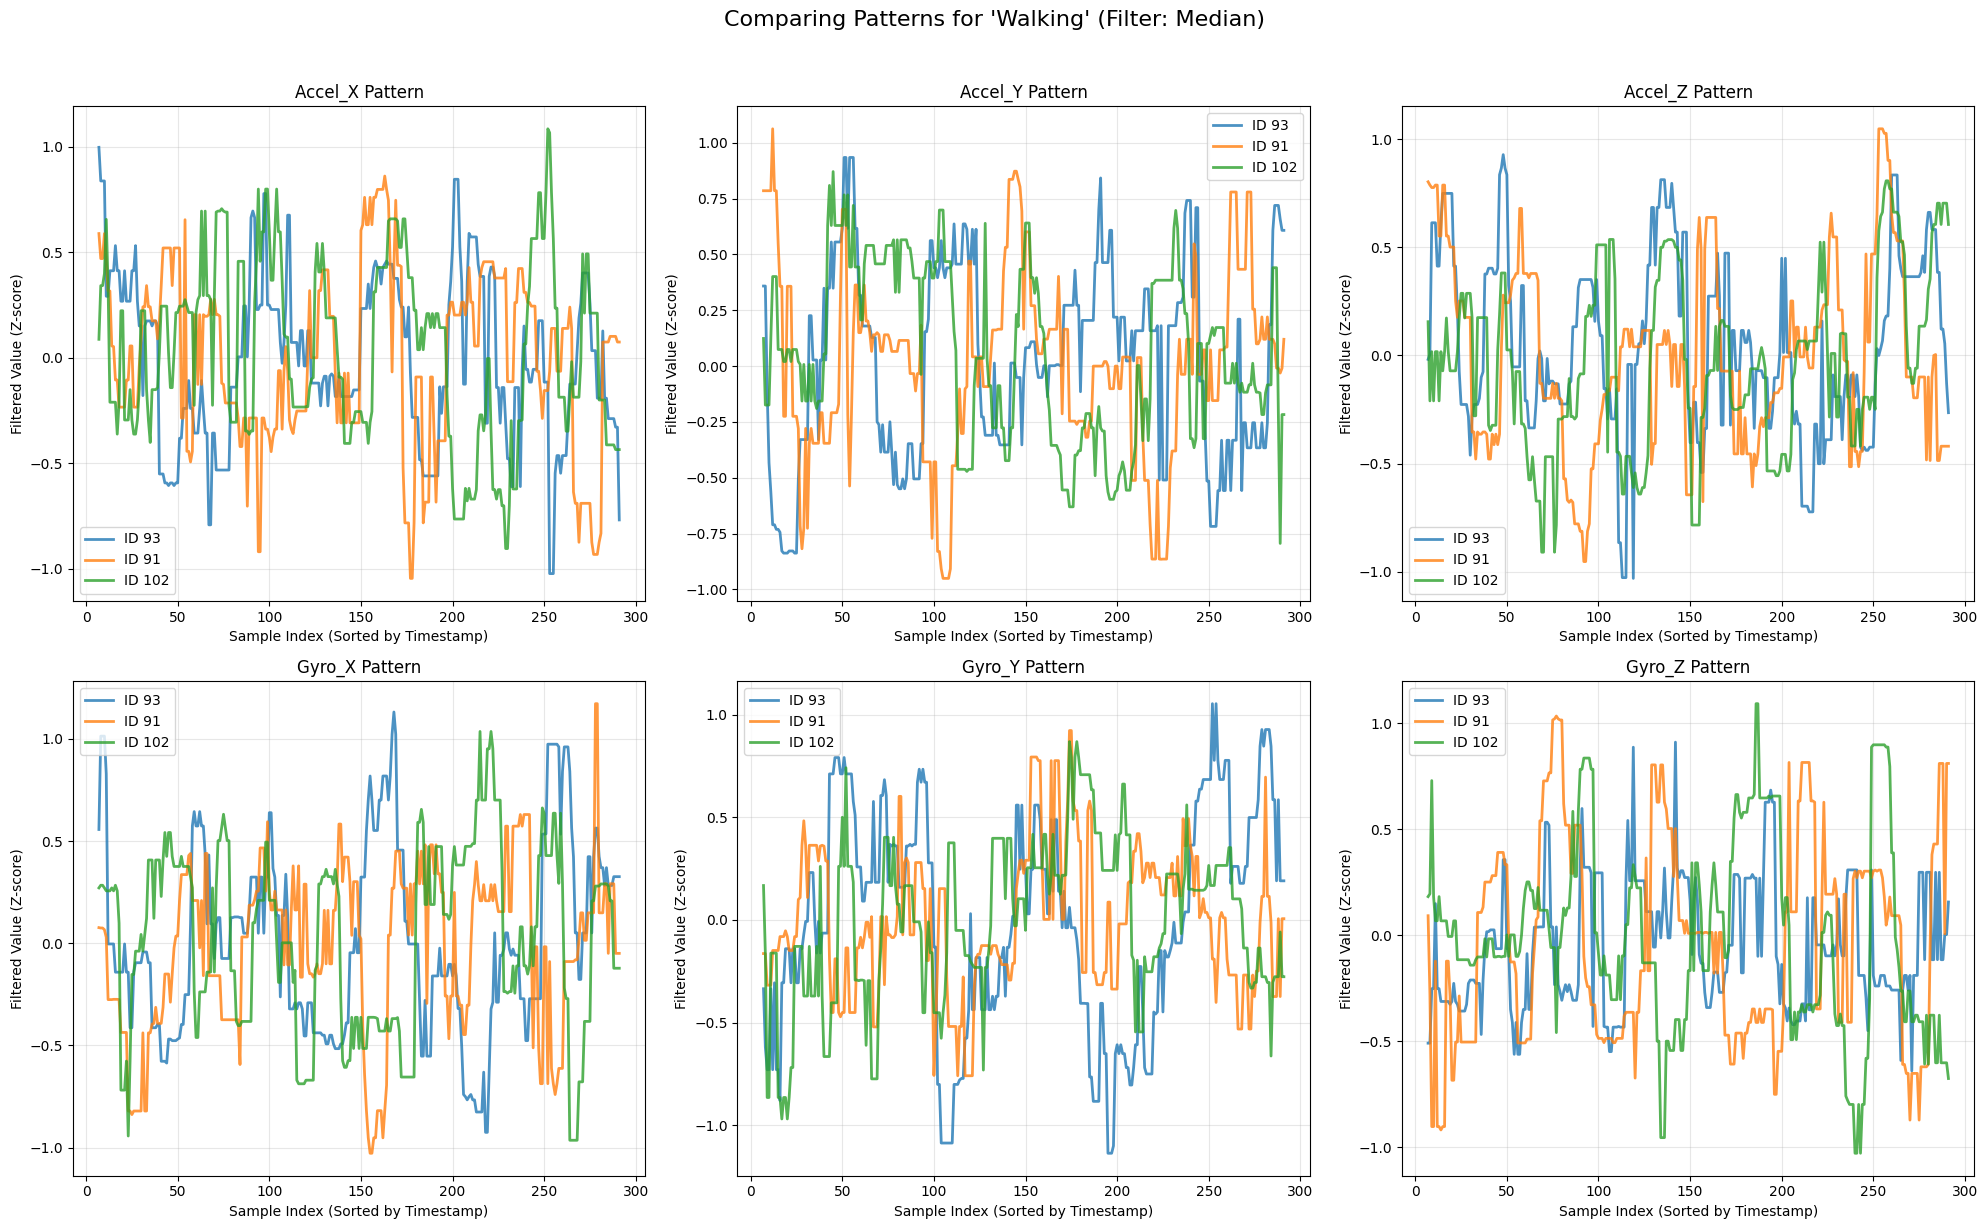

In [12]:
analyze_activity_patterns_by_id(
    train, 
    activity_to_compare='Walking', 
    sample_ids=3,
    filter_type='median', 
    window_size=15
)


ANALYSIS: Comparing 'Arm Waving' (Filter: Butterworth)
Comparing top 3 IDs for 'Arm Waving': [1, 12, 24]


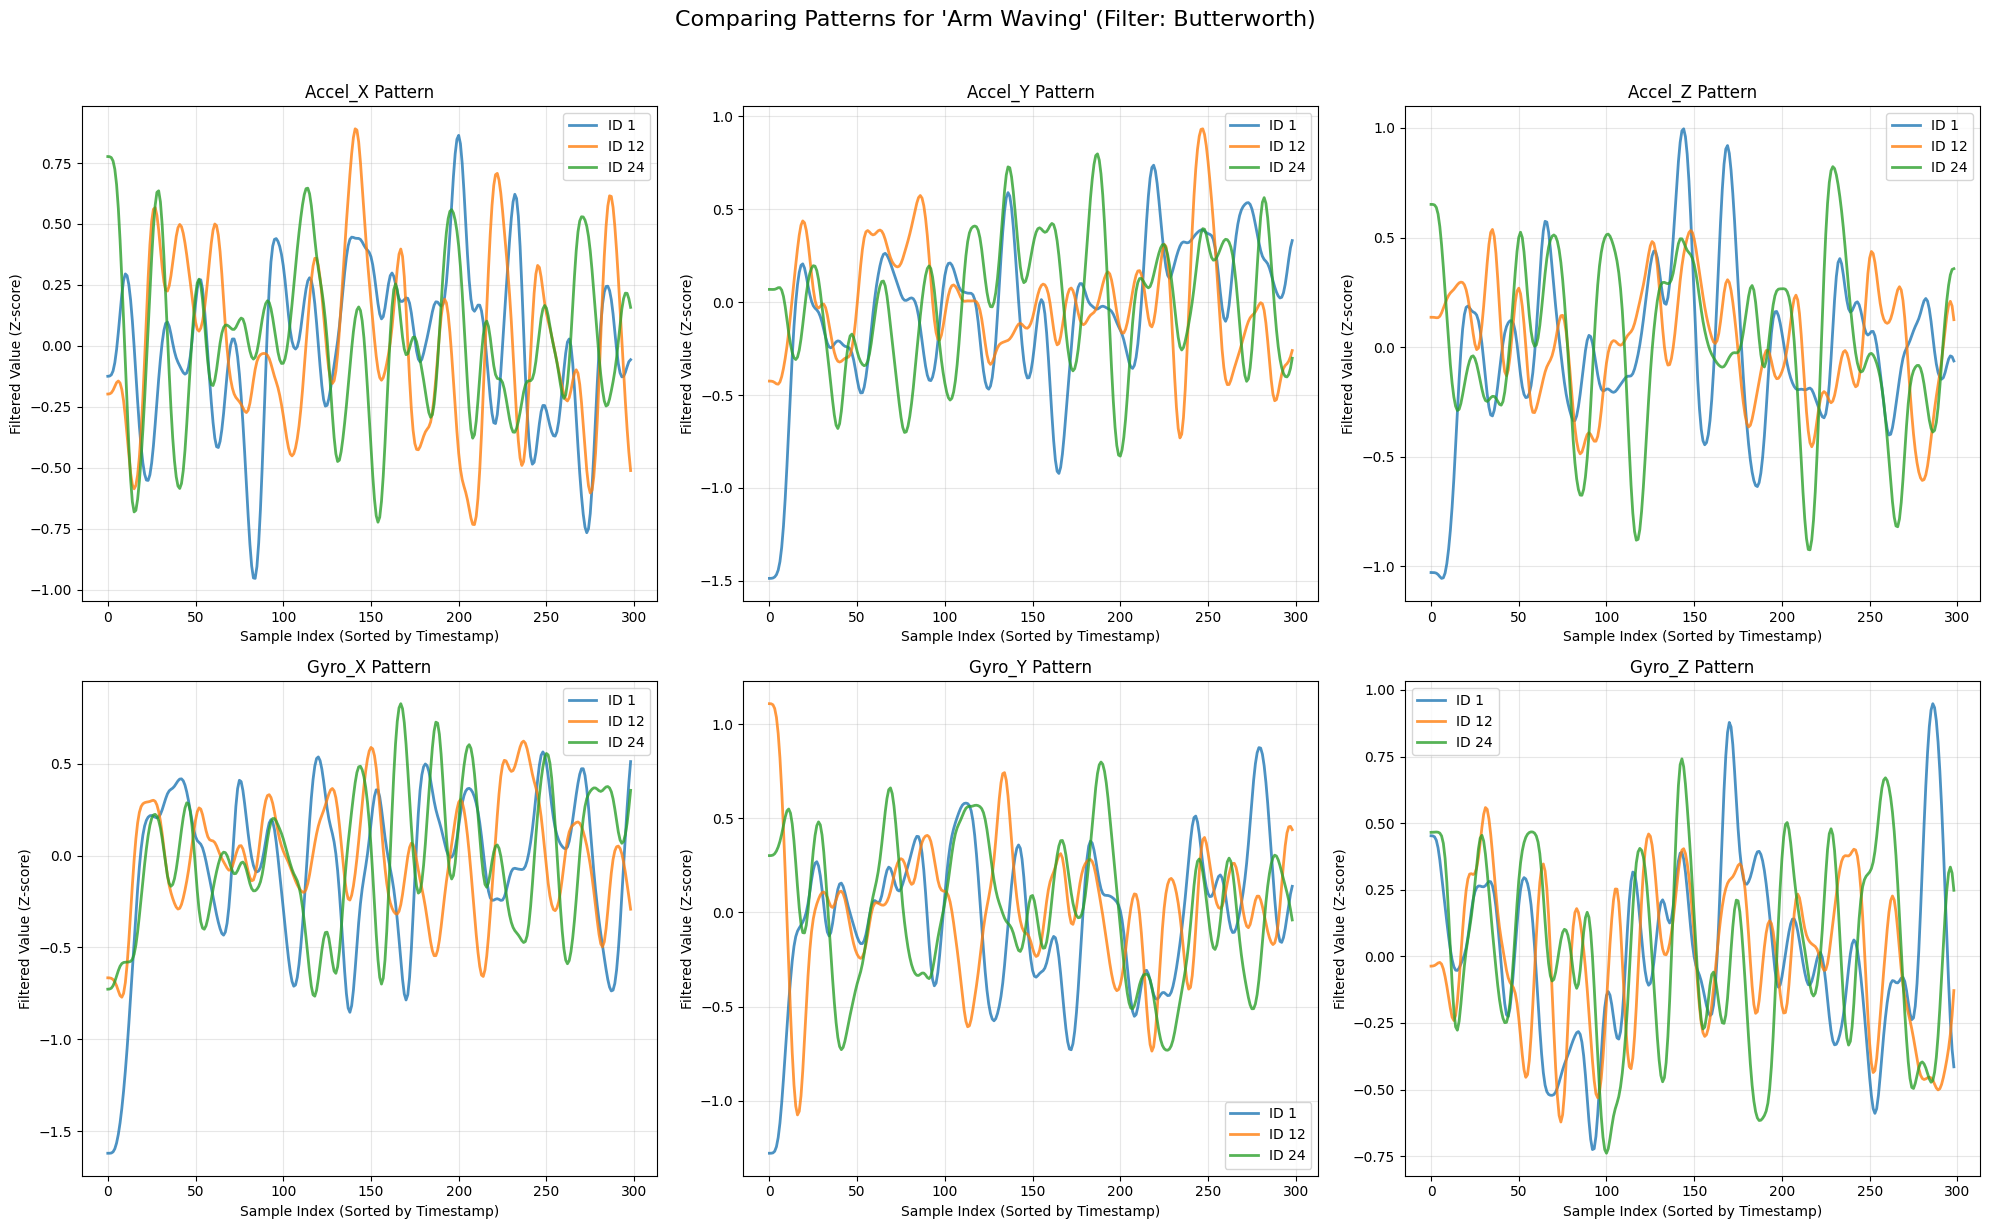

In [13]:
analyze_activity_patterns_by_id(
    train, 
    activity_to_compare='Arm Waving',
    sample_ids=3,
    filter_type='butterworth', 
    butter_order=4, 
    butter_cutoff=0.1
)

ANALYSIS: Comparing 'Sports Action' (Filter: Butterworth)
Comparing top 3 IDs for 'Sports Action': [67, 66, 78]


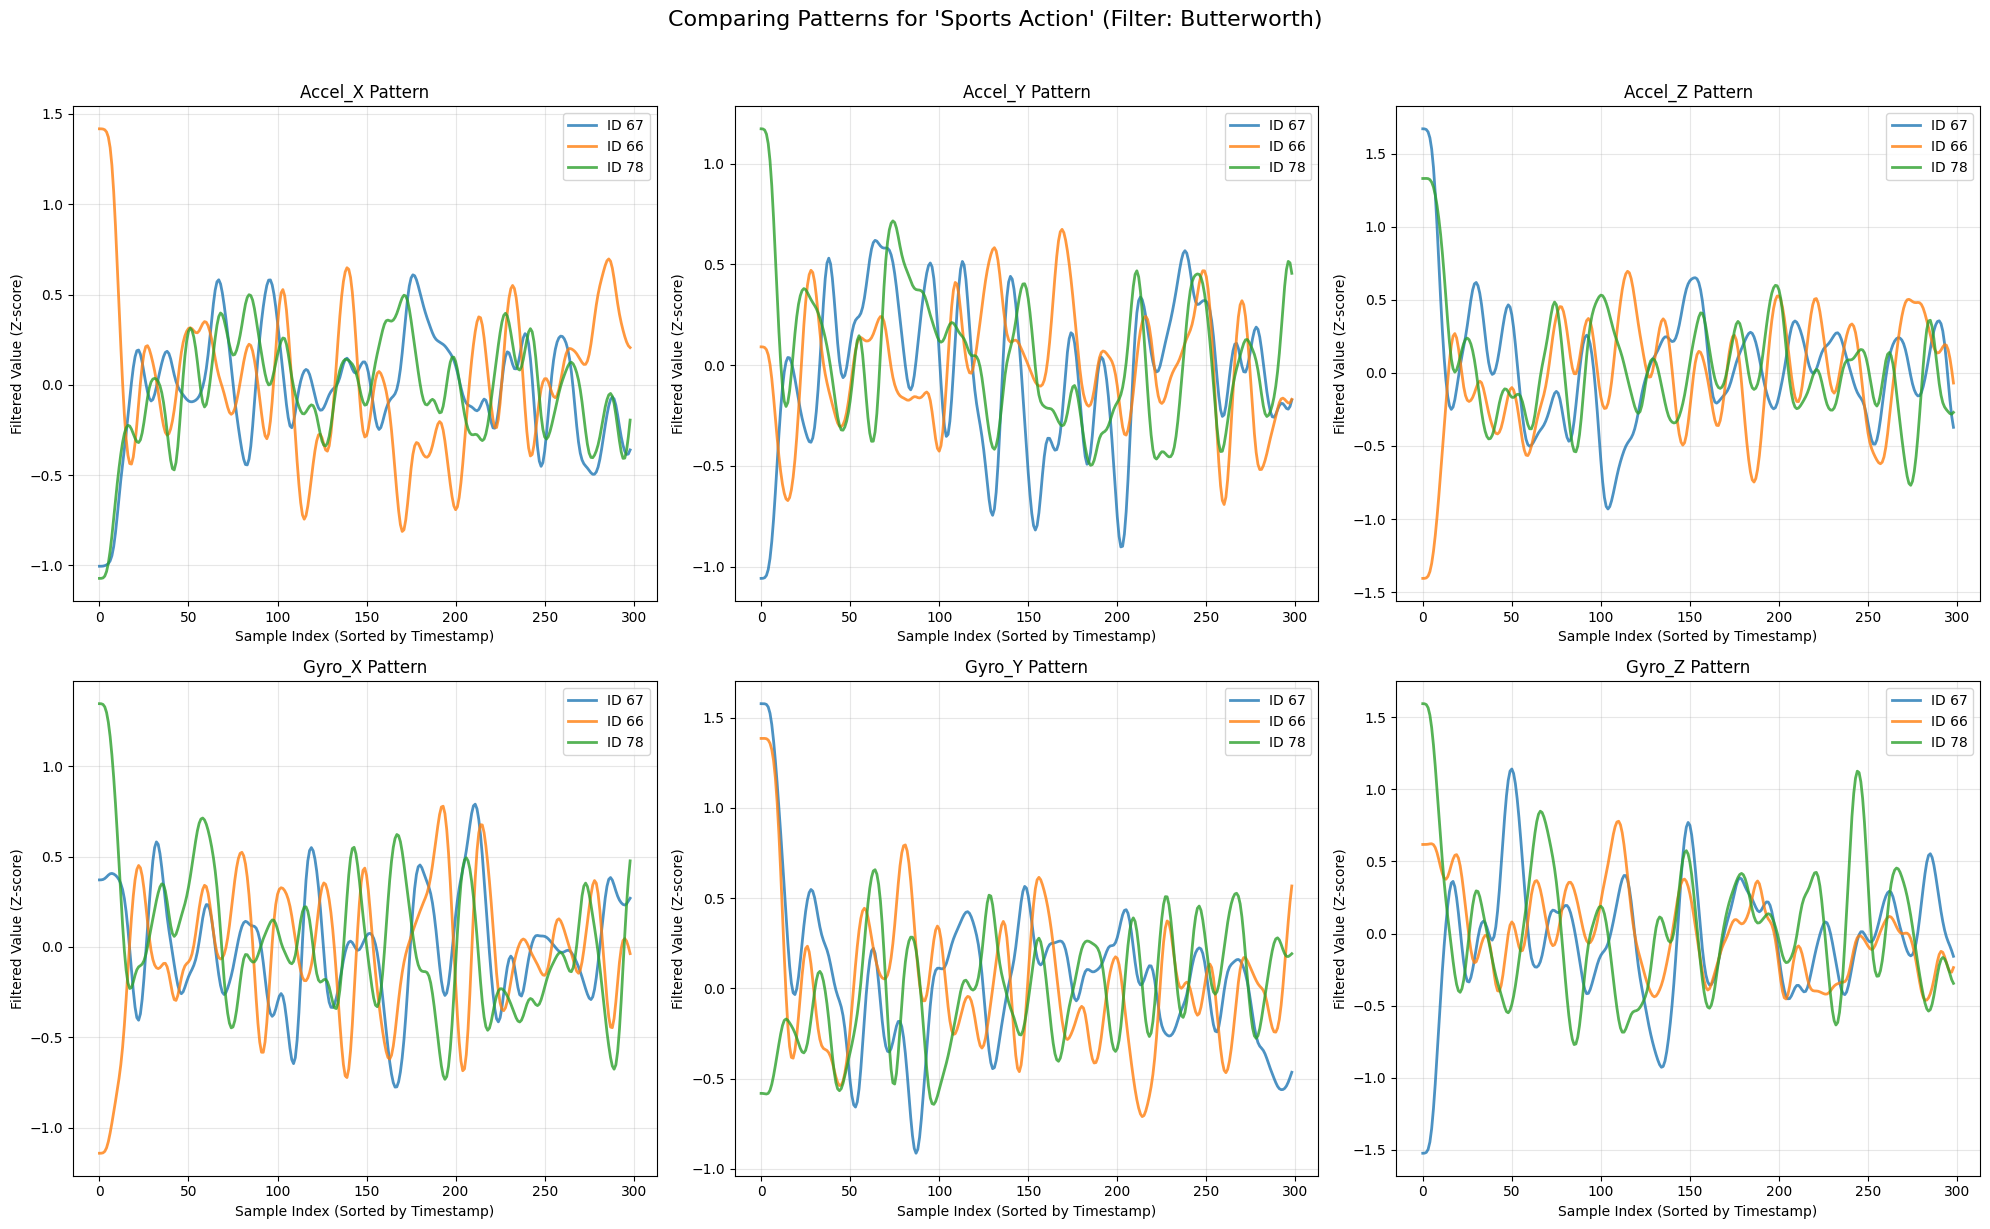

In [14]:
analyze_activity_patterns_by_id(
    train, 
    activity_to_compare='Sports Action',
    sample_ids=3,
    filter_type='butterworth', 
    butter_order=4, 
    butter_cutoff=0.1
)

Ketiga kumpulan grafik ini menampilkan pola akselerometer dan giroskop yang dinormalisasi dan difilter untuk tiga aktivitas berbeda ("Walking", "Arm Waving", dan "Sports Action") dari beberapa ID pengguna terpilih. Untuk **"Walking"**, pola sensor (baik akselerometer maupun giroskop) menunjukkan fluktuasi yang lebih acak dan kurang terstruktur, bahkan setelah penerapan filter median, mengindikasikan sifat gerakan berjalan yang lebih bervariasi antar individu pada tingkat sample instan. Sebaliknya, **"Arm Waving"** dan **"Sports Action"**, yang difilter dengan Butterworth, menunjukkan pola gelombang yang lebih jelas dan periodik pada sebagian besar sumbu sensor. Pola ini konsisten di antara ID yang berbeda untuk aktivitas yang sama, meskipun ada variasi dalam fase atau amplitudo. Keteraturan gelombang pada "Arm Waving" mencerminkan gerakan ayunan yang berulang, sementara "Sports Action" juga menampilkan pola berulang namun dengan kompleksitas dan rentang fluktuasi yang mungkin lebih tinggi, mencerminkan sifatnya yang lebih dinamis dan beragam. 

Secara keseluruhan, visualisasi ini menyoroti bahwa **pola temporal** dan **ritme gerakan**, yang ditangkap oleh filter dan normalisasi, jauh lebih informatif untuk membedakan aktivitas dibandingkan dengan nilai sensor tunggal.

Fungsi `analyze_activity_specific_patterns` memiliki tujuan serupa, tetapi lebih berfokus pada bagaimana sensor berubah seiring waktu untuk setiap aktivitas secara umum dan dikelompokan per sesi (ID), mari kita lihat bagaimana ini bervariasi:

In [15]:
def analyze_activity_specific_patterns(df, sample_ids_per_activity=3, window_size=5):
    print("="*60)
    print("ANALISIS: Pola Temporal Sensor per Aktivitas Spesifik (Dihaluskan)")
    print("="*60)

    activities = df['Activity_Type'].unique()
    sensor_cols = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']

    for activity in activities:
        print(f"\n--- Menganalisis Aktivitas: {activity} ---")

        activity_df = df[df['Activity_Type'] == activity].copy() 

        if activity_df.empty:
            print(f"Tidak ada data ditemukan untuk aktivitas '{activity}'. Melanjutkan...")
            continue

        id_counts_for_activity = activity_df['ID'].value_counts()

        selected_ids = id_counts_for_activity.head(sample_ids_per_activity).index
        print(f"Menampilkan ID representatif: {list(selected_ids)}")

        fig, axes = plt.subplots(2, 3, figsize=(20, 10))
        axes = axes.flatten()

        for i, sensor in enumerate(sensor_cols):
            ax = axes[i]

            for id_val in selected_ids:
                data_subset = activity_df[activity_df['ID'] == id_val].sort_values('Timestamp').copy()

                if not data_subset.empty:

                    mean_val = data_subset[sensor].mean()
                    std_val = data_subset[sensor].std()
                    normalized_signal = (data_subset[sensor] - mean_val) / std_val if std_val != 0 else data_subset[sensor] - mean_val

                    smoothed_signal = normalized_signal.rolling(window=window_size, center=True).median()

                    ax.plot(range(len(data_subset)), smoothed_signal,
                            alpha=0.8, linewidth=1.5,
                            label=f'ID {id_val}')

            ax.set_title(f'Pola {sensor} untuk "{activity}" (Dihaluskan)')
            ax.set_xlabel('Indeks Sampel (Urutan Waktu)')
            ax.set_ylabel(f'Nilai {sensor} (Normalisasi Z-score)')
            ax.legend()
            ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.suptitle(f'Perbandingan Pola Sensor untuk Aktivitas: {activity} (Dihaluskan)', fontsize=16)
        plt.show()

ANALISIS: Pola Temporal Sensor per Aktivitas Spesifik (Dihaluskan)

--- Menganalisis Aktivitas: Arm Waving ---
Menampilkan ID representatif: [1, 12, 24]


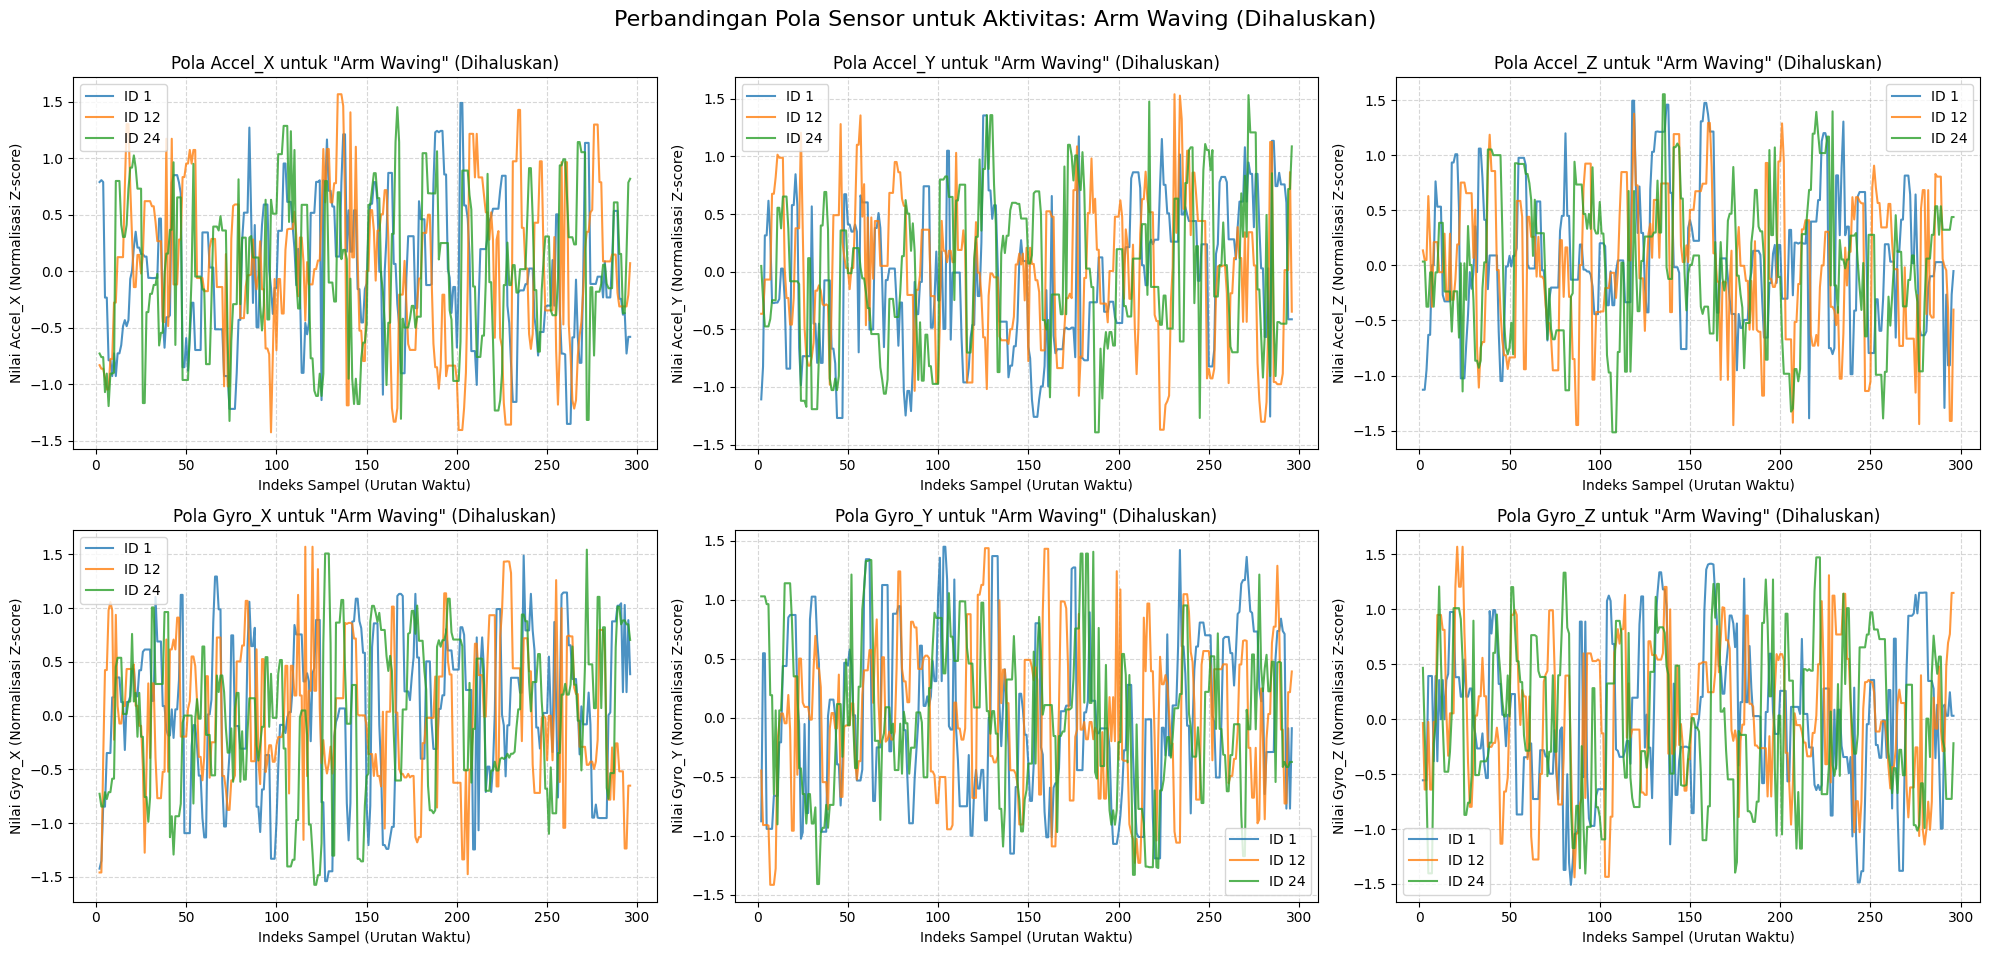


--- Menganalisis Aktivitas: Jumping ---
Menampilkan ID representatif: [27, 28, 51]


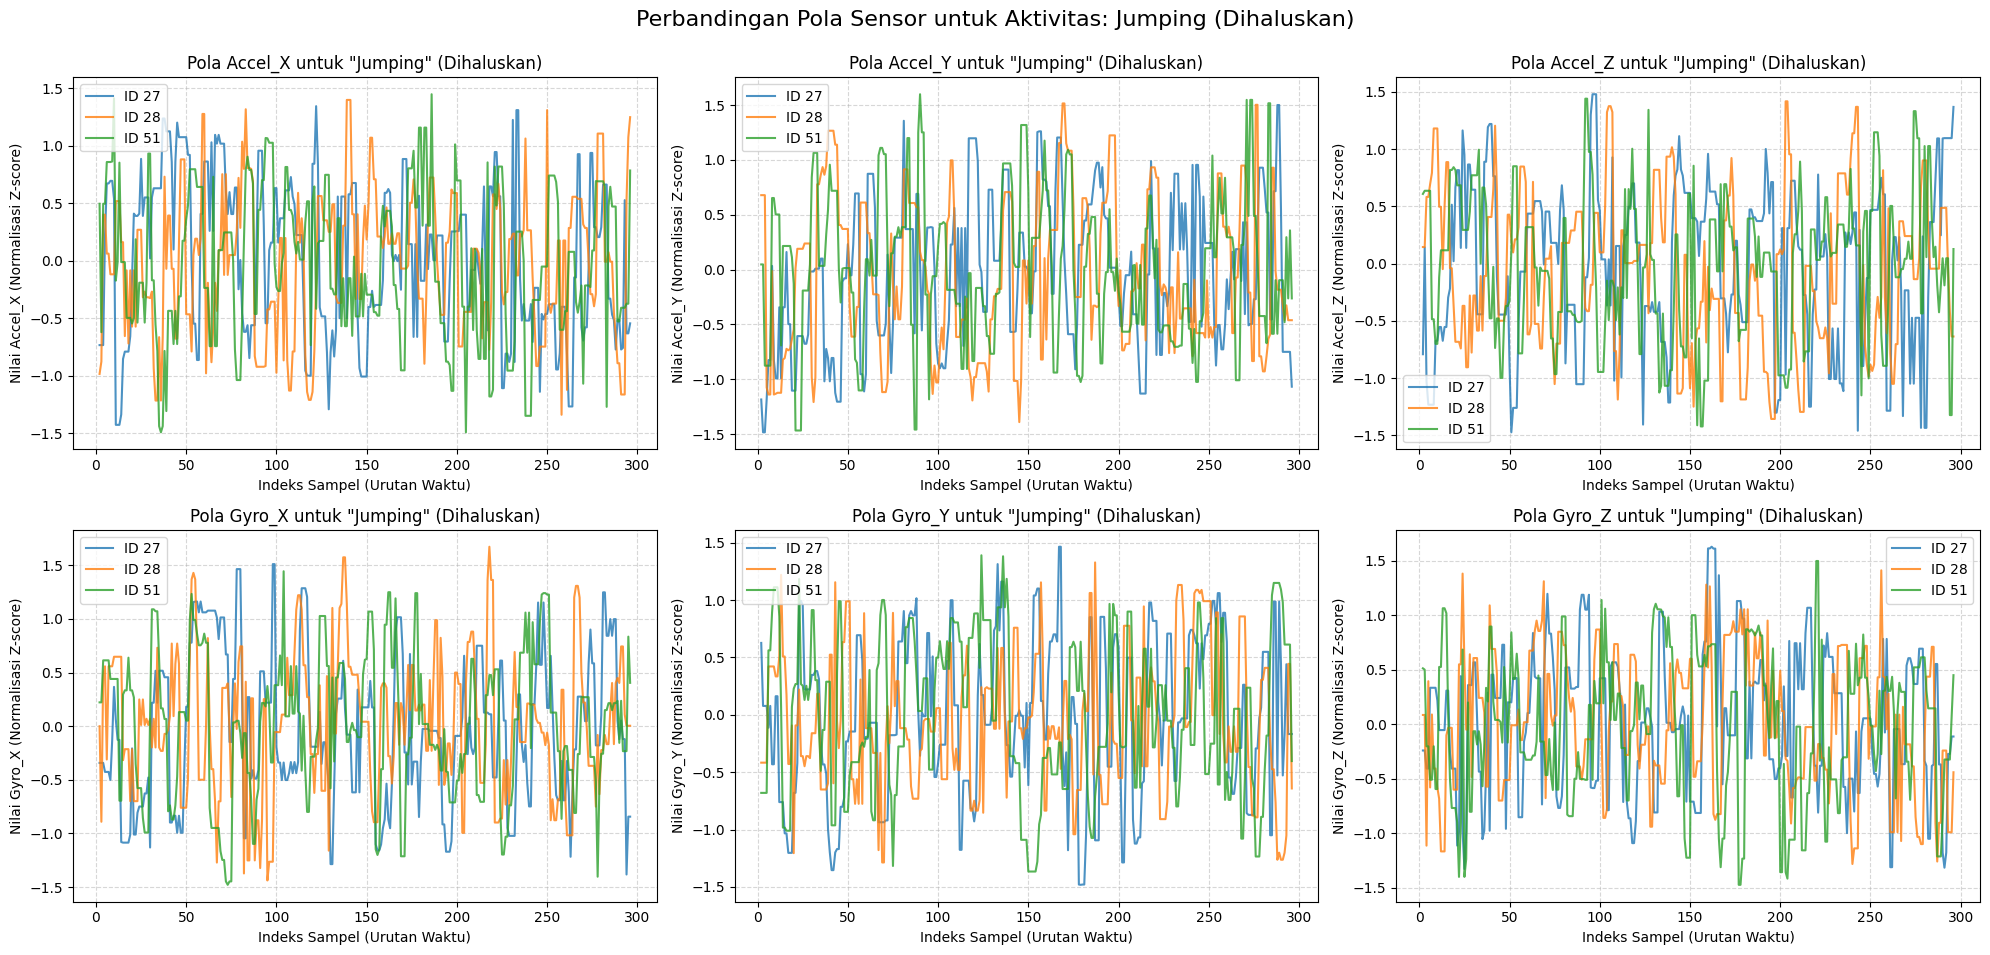


--- Menganalisis Aktivitas: Sports Action ---
Menampilkan ID representatif: [67, 66, 78]


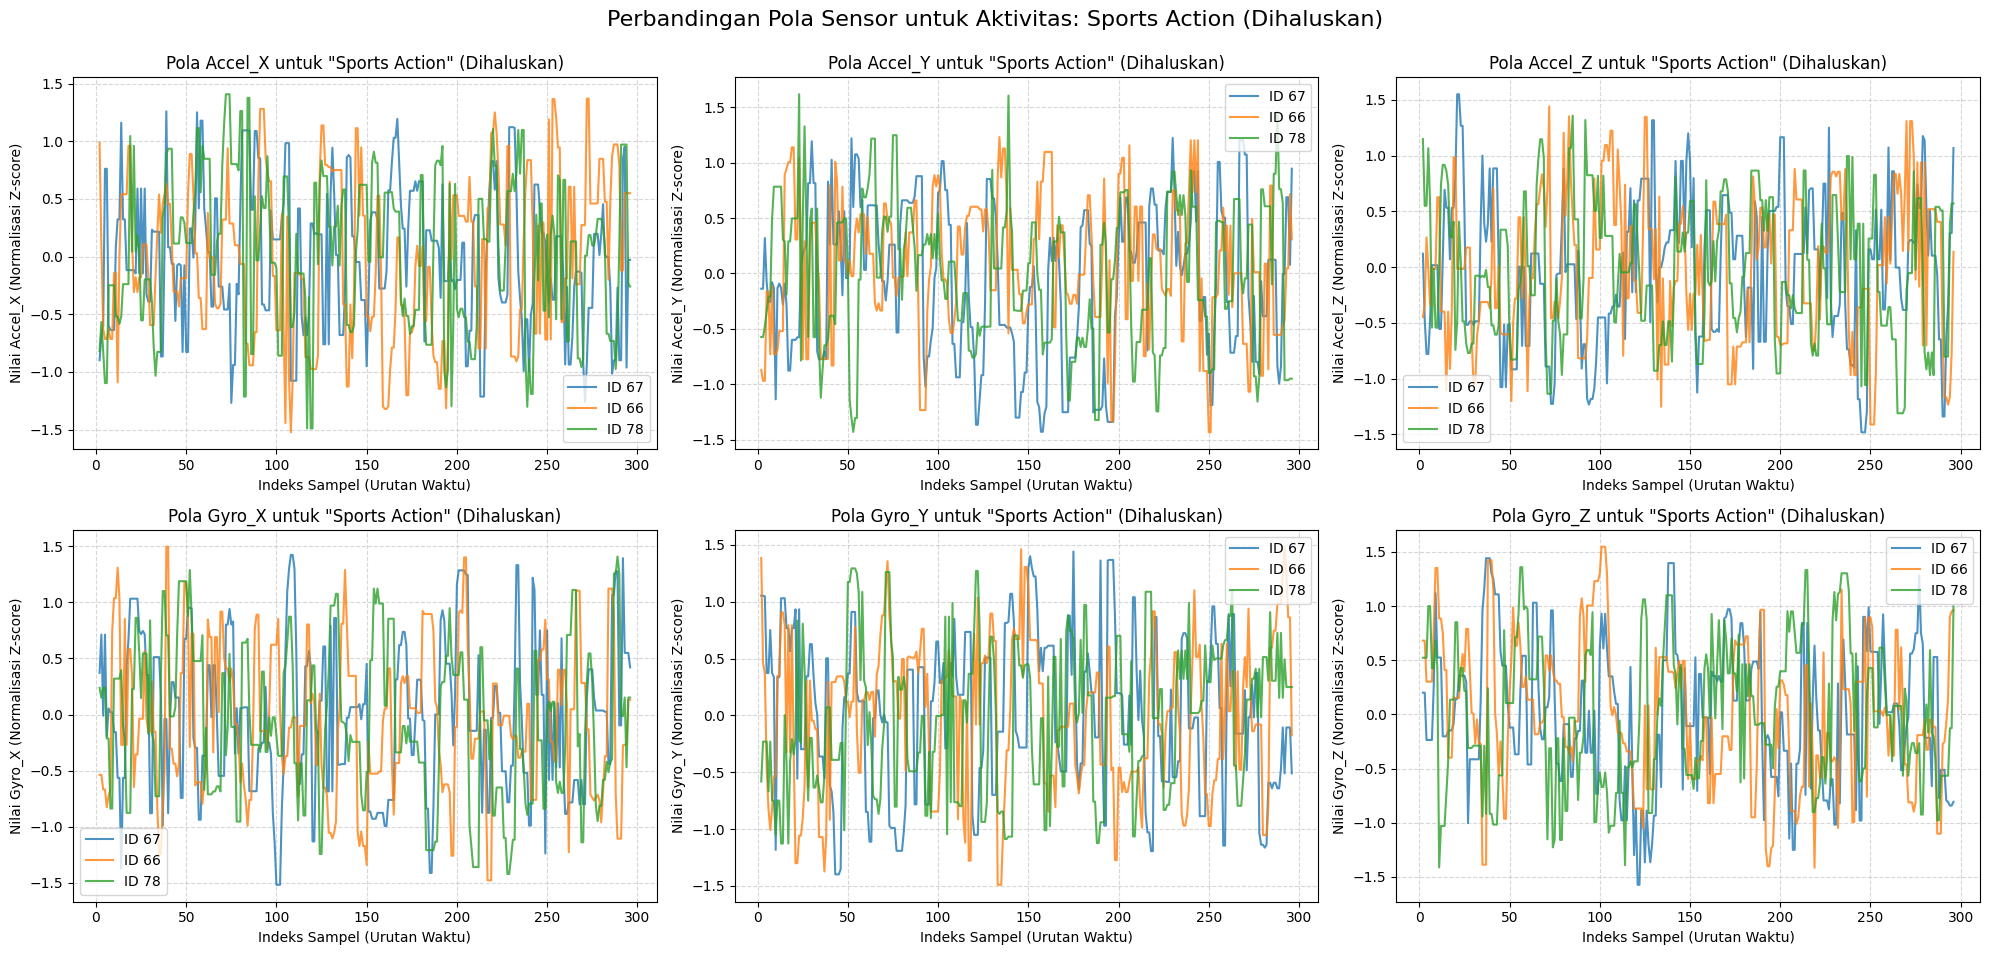


--- Menganalisis Aktivitas: Walking ---
Menampilkan ID representatif: [93, 91, 102]


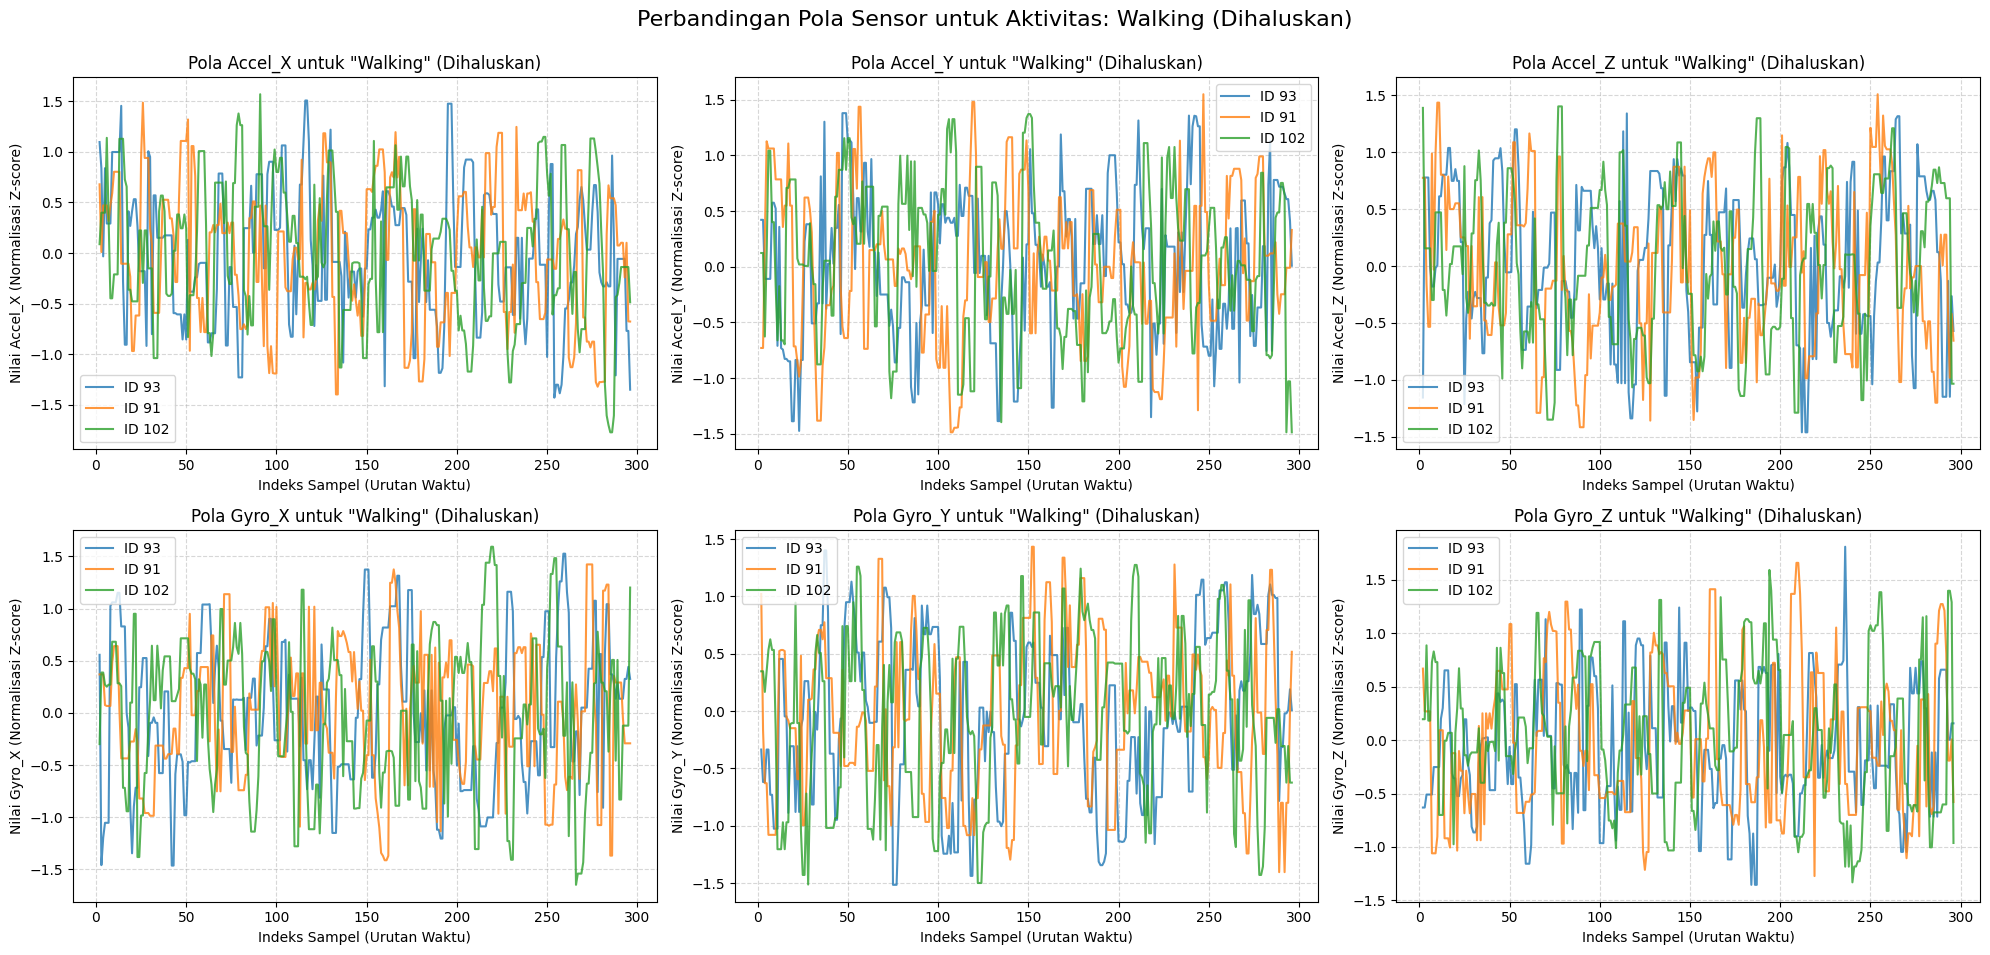

In [16]:
analyze_activity_specific_patterns(train, sample_ids_per_activity=3)

Grafik ini menampilkan pola akselerometer dan giroskop yang dinormalisasi dan dihaluskan untuk semua aktivitas dari beberapa ID sesi. ID di sini hanya mrepresentasikan sesi,  di mana setiap sesi bisa menggunakan sensor yang berbeda atau memiliki urutan perekaman yang bervariasi.

Oleh karena itu, meskipun aktivitasnya sama, pola gelombang dari ID yang berbeda mungkin tidak sepenuhnya selaras atau menunjukkan fase yang sama. Misalnya, pada aktivitas "Jumping", terlihat adanya fluktuasi pada sumbu akselerometer dan giroskop untuk ID 27, 28, dan 51, tetapi puncak dan lembah dari gelombang tersebut tidak selalu terjadi pada indeks sampel yang sama antar ID. Hal yang serupa terjadi pada "Sports Action" untuk ID 67, 68, dan 78. Ini karena setiap **ID mewakili sesi independen**, di mana **posisi awal perangkat, orientasi sensor, atau variasi dalam gaya gerakan individu dapat berbeda**, menyebabkan pergeseran pada pola temporal. 

Meskipun demikian, bentuk umum fluktuasi (misalnya, adanya osilasi atau perubahan nilai yang signifikan) masih dapat memberikan informasi penting mengenai karakteristik aktivitas, terlepas dari perbedaan fase atau offset antar sesi. Ini menegaskan bahwa model perlu belajar dari pola umum dan fitur statistik yang menangkap dinamika gerakan, bukan hanya keteraturan fase yang ketat.

## Data Preprocessing

Pre-processing data dalam *notebook* ini terbilang minimal karena data yang disediakan **sudah relatif bersih** dari awal. Hasil pemeriksaan awal menunjukkan **tidak adanya duplikasi maupun nilai yang hilang** di ketiga set data (train, valid, test). Ini mengurangi kebutuhan akan teknik *imputasi* atau *penanganan duplikasi* yang kompleks. Meskipun ada fungsi `clean_dataset_individually` yang bertujuan menghapus baris dengan kombinasi `ID` dan `Timestamp` yang langka, eksperimen menunjukkan bahwa **data tanpa proses *drop* atau pembersihan ekstensif pun mampu memberikan skor yang sama baiknya**. Hal ini mengindikasikan bahwa model, khususnya XGBoost, cukup **tangguh terhadap variasi jumlah sampel per `ID`-Timestamp** dan dapat bekerja efektif bahkan dengan *noise* minor. Oleh karena itu, fokus utama dalam persiapan data bergeser dari pembersihan ekstensif ke **rekayasa fitur** yang lebih strategis untuk mengekstrak pola temporal yang kaya dari data sensor yang sudah berkualitas baik.

### 1. Data Cleaning Function

Fungsi `clean_dataset_individually` di *notebook* ini bertujuan untuk **menghapus baris-baris data yang dianggap tidak representatif atau *noisy***. Alasan di balik langkah *drop* ini adalah untuk **menjaga konsistensi temporal** dan **kualitas data**. Setiap `Timestamp` seharusnya berhubungan dengan sejumlah sampel sensor tertentu, biasanya 10, namun bisa kurang karena *missing data*. Dengan menghapus kombinasi `ID` dan `Timestamp` yang muncul kurang dari ambang batas (dalam hal ini 3), kita memastikan bahwa setiap "blok" waktu untuk setiap `ID` memiliki jumlah sampel yang memadai, sehingga pola gerakan yang terekam lebih stabil dan utuh.

In [17]:
def clean_dataset_individually(df):
    
    timestamp_counts = df.groupby('ID')['Timestamp'].value_counts()
    
    rare_events = timestamp_counts[timestamp_counts < 3]
    
    if rare_events.empty:
        return df
    
    rare_events_df = rare_events.reset_index()[['ID', 'Timestamp']]
    
    merged_df = pd.merge(df, rare_events_df, on=['ID', 'Timestamp'], 
                        how='left', indicator=True)
    cleaned_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
    
    return cleaned_df

print("Before cleaning:")
print(f"Train: {train.shape}, Valid: {valid.shape}, Test: {test.shape}")

train = clean_dataset_individually(train)
valid = clean_dataset_individually(valid)
test = clean_dataset_individually(test)

print("After cleaning:")
print(f"Train: {train.shape}, Valid: {valid.shape}, Test: {test.shape}")

Before cleaning:
Train: (31608, 9), Valid: (5974, 9), Test: (11943, 8)
After cleaning:
Train: (31549, 9), Valid: (5958, 9), Test: (11918, 8)


Dalam *notebook* ini, fungsi `clean_dataset_individually` memang dirancang untuk menghapus baris di mana kombinasi `ID` dan `Timestamp` muncul kurang dari ambang batas tertentu, dengan kode yang disajikan menggunakan ambang batas `3` (`rare_events = timestamp_counts[timestamp_counts < 3]`). Namun, penting untuk dicatat bahwa **submisi terakhir saat ini *menggunakan* pembersihan dengan ambang batas `3` ini**, tidak seperti percobaan sebelumnya yang menonaktifkannya.

Eksperimen awal yang dilakukan menunjukkan bahwa ketika pembersihan diaktifkan dengan ambang batas `10` (yaitu, menghapus kombinasi `ID`-Timestamp yang muncul kurang dari 10 kali), performa model pada validasi justru memburuk, terutama merusak urutan data (*sequence*) pada `ID` terakhir. Anehnya, hasil submisi tanpa proses *drop* sama baiknya dengan hasil yang menggunakan pembersihan. Namun, untuk *best approach* pada submisi terkini, **pembersihan dengan ambang batas `3` inilah yang digunakan**. Ini mengindikasikan bahwa ambang batas `3` dianggap sebagai titik optimal yang cukup untuk menghilangkan *noise* tanpa merusak integritas *sequence* data atau mengorbankan performa model secara signifikan.

## Feature Engineering

### 1. Lag Features Creation

In [18]:
def create_simple_lag_features(df, num_lags=3):
    """
    Membuat fitur lag sederhana (1, 2, 3) untuk kolom sensor
    """
    sensor_cols = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z']
    
    # Ensure data is sorted properly
    df_sorted = df.sort_values(by=['ID', 'Timestamp']).copy()
    
    # Create lag features
    for lag in range(1, num_lags + 1):
        for col in sensor_cols:
            df_sorted[f'{col}_lag_{lag}'] = df_sorted.groupby('ID')[col].shift(lag)
            
    return df_sorted

# Apply lag features
train_with_lags = create_simple_lag_features(train, num_lags=3)
valid_with_lags = create_simple_lag_features(valid, num_lags=3)
test_with_lags = create_simple_lag_features(test, num_lags=3)

print("Lag features created successfully!")

Lag features created successfully!


Approach ini dibuat berdasarkan pada :

- Menangkap Ketergantungan Temporal: Sensor time series memiliki ketergantungan antar pembacaan berurutan. Nilai akselerasi saat ini sangat dipengaruhi oleh nilai beberapa saat sebelumnya. Fitur lag (misalnya, `Accel_X_lag_1`, `Accel_X_lag_2`, `Accel_X_lag_3`) secara eksplisit menangkap informasi ini.

- Konteks Gerakan: Dengan mengetahui nilai sensor di t, t−1, t−2, dan t−3, model dapat memahami arah dan kecepatan perubahan. Contoh: jika Accel_X saat ini positif tetapi `Accel_X_lag_1` negatif, ini menunjukkan perubahan arah gerakan.

- Aproksimasi Turunan: Selisih antara nilai saat ini dan nilai lag 1 (lag 1 adalah nilai sebelumnya) adalah bentuk aproksimasi numerik dari turunan pertama, yang menunjukkan tingkat perubahan.

Kita membuat 3 lag untuk setiap kolom sensor (`Accel_X/Y/Z, Gyro_X/Y/Z`), menghasilkan `3 * 6 = 18` fitur lag baru. Data diurutkan berdasarkan ID dan Timestamp sebelum membuat lag untuk memastikan bahwa nilai lag berasal dari urutan waktu yang benar dalam sesi yang sama.

### 2. Instantaneous Features



Fitur ini berfokus pada sifat fisik langsung yang dapat diturunkan dari data sensor, memberikan wawasan tambahan tentang dinamika gerakan.

### Magnitude

**Magnitude** dihitung untuk akselerasi dan giroskop, merepresentasikan besar vektor total dari ketiga sumbu (X, Y, Z).

$$\text{Accel\_Mag} = \sqrt{\text{Accel\_X}^2 + \text{Accel\_Y}^2 + \text{Accel\_Z}^2}$$
$$\text{Gyro\_Mag} = \sqrt{\text{Gyro\_X}^2 + \text{Gyro\_Y}^2 + \text{Gyro\_Z}^2}$$

Magnitude adalah fitur yang **rotasi-invariant**. Ini berarti nilai besar akselerasi atau rotasi tidak terpengaruh oleh orientasi perangkat atau sensor di ruang 3D. Dalam konteks aktivitas manusia, di mana perangkat mungkin diputar atau dipegang dalam berbagai orientasi, fitur magnitude memberikan representasi yang lebih stabil dan konsisten mengenai **"kekuatan" atau intensitas gerakan keseluruhan**, terlepas dari bagaimana sensor diposisikan. [Saha, 2023](#saha)

### Jerk

**Jerk** adalah turunan pertama dari akselerasi terhadap waktu, atau secara intuitif, **"perubahan akselerasi"**. Dalam data diskrit, Jerk diaproksimasi sebagai selisih antara nilai akselerasi saat ini dan nilai akselerasi sebelumnya.

$$\text{Jerk}(t) \approx a(t) - a(t-1)$$

Mirip dengan magnitude akselerasi, **Jerk Magnitude** juga dihitung untuk memberikan representasi skalar total perubahan akselerasi.

$$\text{Jerk}_{\text{mag}} = \sqrt{\text{Jerk}_x^2 + \text{Jerk}_y^2 + \text{Jerk}_z^2}$$

Fitur Jerk sangat penting karena menangkap **intensitas dan kualitas perubahan gerakan**. Lonjakan nilai Jerk yang tinggi menunjukkan gerakan yang tiba-tiba, sentakan, atau perubahan kecepatan yang mendadak. Misalnya, membedakan aktivitas "Jumping" dari "Walking" bisa sangat terbantu dengan analisis Jerk, karena gerakan melompat cenderung memiliki nilai Jerk yang lebih tinggi dan lebih sering. Fitur ini menambahkan dimensi informasi temporal yang lebih kaya dibandingkan hanya mengamati nilai akselerasi mentah, memungkinkan model untuk memahami dinamika gerakan yang lebih kompleks. [Hanalainen, 2011](#hanalainen)


Fungsi `create_instantaneous_features` ini bertugas mengambil DataFrame yang sudah memiliki fitur lag (karena perhitungan Jerk memerlukan nilai akselerasi sebelumnya) dan kemudian menambahkan semua fitur instan yang telah dijelaskan di atas: magnitude untuk akselerometer dan giroskop, serta Jerk untuk setiap sumbu dan Jerk magnitude keseluruhan. [Yamane et al., 2025](#yamane)

In [19]:
def create_instantaneous_features(df):

    df_featured = df.copy()

    df_featured['Accel_Mag'] = np.sqrt(
        df_featured['Accel_X']**2 + 
        df_featured['Accel_Y']**2 + 
        df_featured['Accel_Z']**2
    )
    df_featured['Gyro_Mag'] = np.sqrt(
        df_featured['Gyro_X']**2 + 
        df_featured['Gyro_Y']**2 + 
        df_featured['Gyro_Z']**2
    )

    for axis in ['X', 'Y', 'Z']:
        if f'Accel_{axis}_lag_1' in df_featured.columns:
            df_featured[f'Accel_{axis}_Jerk'] = (
                df_featured[f'Accel_{axis}'] - df_featured[f'Accel_{axis}_lag_1']
            )
        
        if f'Gyro_{axis}_lag_1' in df_featured.columns:
            df_featured[f'Gyro_{axis}_Jerk'] = (
                df_featured[f'Gyro_{axis}'] - df_featured[f'Gyro_{axis}_lag_1']
            )

    jerk_cols = ['Accel_X_Jerk', 'Accel_Y_Jerk', 'Accel_Z_Jerk']
    if all(col in df_featured.columns for col in jerk_cols):
        df_featured['Accel_Jerk_Mag'] = np.sqrt(
            df_featured['Accel_X_Jerk']**2 + 
            df_featured['Accel_Y_Jerk']**2 + 
            df_featured['Accel_Z_Jerk']**2
        )

    return df_featured

### 3. Rolling & Diff Window Features

Rolling features ini mampu mengatasi minimanya konteks data. Satu titik data sensor tunggal (misalnya, `Accel_X = 1.5`) memiliki sedikit makna jika dilihat terpisah. Apakah nilai tersebut merupakan puncak, bagian dari tren, atau hanya noise? Fitur rolling menyediakan konteks temporal dengan mempertimbangkan serangkaian pembacaan di sekitarnya. Ini memungkinkan model untuk "melihat" pola gerakan, bukan hanya snapshot sesaat.

In [20]:
def create_rolling_features(df, window_sizes=[3, 5, 7]):
    """
    Membuat fitur rolling window untuk statistical aggregations
    """
    sensor_cols = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Accel_X_Jerk', 'Accel_Y_Jerk', 'Accel_Z_Jerk', 'Accel_Jerk_Mag']
    df_out = df.copy()
    df_out = df_out.sort_values(by=['ID', 'Timestamp']).reset_index(drop=True)
    
    for window in window_sizes:
        for col in sensor_cols:
            # Calculate rolling statistics
            rolling_features = df_out.groupby('ID')[col].rolling(
                window=window, min_periods=1
            ).agg({
                f'{col}_roll_mean_{window}': 'mean',
                f'{col}_roll_std_{window}': 'std',
                f'{col}_roll_min_{window}': 'min',
                f'{col}_roll_max_{window}': 'max',
                f'{col}_roll_median_{window}': 'median'
            })
            
            rolling_features = rolling_features.reset_index(level=0, drop=True)
            df_out = df_out.join(rolling_features)

    # Fill NaN values in std columns with 0
    std_cols = [col for col in df_out.columns if 'roll_std' in col]
    df_out[std_cols] = df_out[std_cols].fillna(0)
            
    return df_out

Kita membuat fitur rolling untuk berbagai ukuran jendela (`window_sizes=[3, 5, 7]`) pada semua kolom sensor asli dan fitur Jerk yang baru dibuat. Parameter `min_periods=1` memastikan bahwa perhitungan dilakukan bahkan jika ada kurang dari jumlah sampel window_size di awal setiap grup ID. Nilai NaN di kolom _roll_std diisi dengan 0 karena standar deviasi tidak terdefinisi untuk jendela dengan hanya satu sampel, dan 0 adalah nilai yang logis untuk kasus tidak ada variasi.

In [21]:
def create_difference_features(df, periods=[1, 2, 3]):
    """
    Membuat fitur perbedaan (selisih) antar waktu.
    Menghitung selisih antara nilai saat ini dan nilai n waktu sebelumnya.
    """
    sensor_cols = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Accel_X_Jerk', 'Accel_Y_Jerk', 'Accel_Z_Jerk', 'Accel_Jerk_Mag']
    df_out = df.copy()
    # Pastikan data diurutkan agar selisihnya benar secara kronologis
    df_out = df_out.sort_values(by=['ID', 'Timestamp']).reset_index(drop=True)
    
    for period in periods:
        for col in sensor_cols:
            # Buat nama kolom baru yang deskriptif
            new_col_name = f'{col}_diff_{period}'
            
            # Hitung selisih untuk setiap grup ID
            # Ini akan menghitung: nilai_sekarang - nilai_n_periode_sebelumnya
            df_out[new_col_name] = df_out.groupby('ID')[col].diff(periods=period)
            
    # Isi nilai NaN yang muncul di awal setiap grup dengan 0 (asumsi tidak ada perubahan awal)
    diff_cols = [col for col in df_out.columns if 'diff' in col]
    df_out[diff_cols] = df_out[diff_cols].fillna(0)
            
    return df_out

Fitur perbedaan mengukur **tingkat dan arah perubahan** nilai sensor seiring waktu. Dihitung sebagai selisih antara nilai saat ini dan nilai dari periode sebelumnya (misalnya, `Accel_X(t) - Accel_X(t-1)`), fitur ini membantu menangkap dinamika gerakan yang cepat atau tiba-tiba pada berbagai skala waktu (`periods=1, 2, 3`). Ini melengkapi fitur *lag* dan *rolling* dengan memberikan wawasan langsung tentang fluktuasi data, dengan `NaN` awal di setiap sesi `ID` diisi `0`.

### 4. Feature Engineering Pipeline

In [22]:
print("Applying feature engineering pipeline...")

train_final = train_with_lags.dropna()
valid_final = valid_with_lags.dropna()
test_final = test_with_lags.dropna()

train_featured = create_instantaneous_features(train_final)
valid_featured = create_instantaneous_features(valid_final)
test_featured = create_instantaneous_features(test_final)

train_featured = create_rolling_features(train_featured)
valid_featured = create_rolling_features(valid_featured)
test_featured = create_rolling_features(test_featured)

train_featured = create_difference_features(train_featured)
valid_featured = create_difference_features(valid_featured)
test_featured = create_difference_features(test_featured)

print("Feature engineering completed!")
print(f"Final feature count: {len(train_featured.columns)}")

Applying feature engineering pipeline...
Feature engineering completed!
Final feature count: 216


### 5. Target Encoding

Model machine learning tidak dapat bekerja langsung dengan label teks seperti `'Walking'` atau `'Jumping'`. Kita perlu mengubahnya menjadi representasi numerik.

In [23]:
def encode_target_variable(train_df, valid_df, target_column='Activity_Type', le=None):

    if le is None:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
    
    train_df[f'{target_column}_Encoded'] = le.fit_transform(train_df[target_column])
    
    valid_df[f'{target_column}_Encoded'] = le.transform(valid_df[target_column])
    
    print("Encoded labels:", list(le.classes_))
    print("Encoding mapping:")
    for i, class_name in enumerate(le.classes_):
        print(f"  {class_name}: {i}")
    
    return le

le = encode_target_variable(train_featured, valid_featured)

Encoded labels: ['Arm Waving', 'Jumping', 'Sports Action', 'Walking']
Encoding mapping:
  Arm Waving: 0
  Jumping: 1
  Sports Action: 2
  Walking: 3


**Feature Engineering Summary:**
- **Original features**: 9 columns
- **After lag features**: +18 columns (3 lags × 6 sensors)
- **After instantaneous features**: +11 columns (magnitudes + jerks)
- **After rolling features**: +90 columns (3 windows × 6 sensors × 5 stats)
- **Total features**: ~128 columns

## Model Development

Setelah data disiapkan dengan fitur, saatnya membangun model. Kita akan menggunakan XGBoost (Extreme Gradient Boosting), yang merupakan algoritma ensemble tree yang sangat powerful dan sering menjadi pilihan utama untuk data tabel.

### 1. Data Preparation

Fungsi `prepare_data_splits` ini bertujuan untuk memisahkan dataset ke dalam set fitur (X) dan target (y) untuk pelatihan, validasi, dan pengujian. **Kolom `ID`, `Activity_Type`, dan `Activity_Type_Encoded` dikecualikan** dari set fitur karena merupakan pengidentifikasi atau variabel target. Ini memastikan model hanya dilatih pada fitur prediktif. Fungsi ini mengembalikan `X_train`, `y_train`, `X_val`, `y_val`, dan `X_test` yang siap untuk pemodelan.

In [24]:
def prepare_data_splits(train_df, valid_df, test_df, target_col='Activity_Type_Encoded'):
    """
    Prepare data splits for modeling
    """
    cols_to_exclude = ['ID', 'Activity_Type', 'Activity_Type_Encoded']
    features_cols = [col for col in train_df.columns if col not in cols_to_exclude]
    
    X_train = train_df[features_cols]
    y_train = train_df[target_col]
    X_val = valid_df[features_cols]
    y_val = valid_df[target_col]
    
    X_test = test_df[[col for col in features_cols if col in test_df.columns]]
    
    return X_train, y_train, X_val, y_val, X_test

# Prepare data
cols_to_exclude = ['ID', 'Activity_Type', 'Activity_Type_Encoded']
features_cols = [col for col in train_featured.columns if col not in cols_to_exclude]
target_col = 'Activity_Type_Encoded'

Kode ini menyiapkan data untuk pemodelan dengan membaginya menjadi set fitur (X) dan set target (y) untuk pelatihan, validasi, dan pengujian. Pertama, **kolom fitur (`features_cols`) dipilih** dengan mengecualikan kolom `ID`, `Activity_Type`, dan `Activity_Type_Encoded` dari data yang sudah direkayasa fiturnya, memastikan hanya fitur prediktif yang digunakan.

Langkah krusial berikutnya adalah **menyelaraskan kolom `X_test` dengan `X_train`**. Urutan kolom `X_test` disesuaikan agar cocok dengan `X_train`. Ini sangat penting untuk **kompatibilitas model** dan mencegah kesalahan selama prediksi, karena model *machine learning* mengharapkan fitur masukan yang konsisten.

Selanjutnya, kolom `Timestamp` yang tidak memiliki makna numerik untuk urutan, diubah menjadi **fitur `window_id` kategorikal** menggunakan `astype('category').cat.codes`. Transformasi ini mengubah setiap `Timestamp` unik menjadi ID integer yang berbeda, memungkinkan model seperti XGBoost untuk memperlakukan jendela waktu sebagai kelompok kategorikal, bahkan jika `timestamp` baru muncul di set pengujian. Terakhir, kolom `Timestamp` asli dihapus karena informasinya sudah ditangkap oleh `window_id`, dan bentuk akhir dari `X_train`, `X_val`, serta `X_test` dicetak untuk verifikasi.

In [25]:
pd.options.mode.chained_assignment = None

X_train = train_featured[features_cols]
y_train = train_featured[target_col]
X_val = valid_featured[features_cols]
y_val = valid_featured[target_col]
X_test = test_featured[[col for col in features_cols if col in test_featured.columns]]

missing_cols_in_test = set(X_train.columns) - set(X_test.columns)
for c in missing_cols_in_test:
    X_test[c] = np.nan
X_test = X_test[X_train.columns]


X_train['window_id'] = X_train['Timestamp'].astype('category').cat.codes
X_val['window_id'] = X_val['Timestamp'].astype('category').cat.codes
X_test['window_id'] = X_test['Timestamp'].astype('category').cat.codes

X_train.drop(columns = ['Timestamp'], inplace = True)
X_val.drop(columns = ['Timestamp'], inplace = True)
X_test.drop(columns = ['Timestamp'], inplace = True)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_val.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (31231, 214)
Validation features shape: (5898, 214)
Test features shape: (11798, 214)


### 2. Cross-Validation Setup


In [26]:
from sklearn.model_selection import StratifiedKFold

def perform_xgb_cross_validation(X_train, y_train, num_classes, n_splits=5, random_state=42):
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_accuracies = []
    
    print(f"Starting {n_splits}-Fold Stratified Cross-Validation...")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"\n--- Fold {fold + 1}/{n_splits} ---")
        
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # XGBoost model configuration
        xgb_model = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=num_classes,
            eval_metric='mlogloss',
            use_label_encoder=False,
            enable_categorical=True,
            tree_method='hist',
            random_state=random_state,
            early_stopping_rounds=50
        )
        
        # Train model
        xgb_model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            verbose=False
        )
        
        # Make predictions
        y_pred_fold = xgb_model.predict(X_val_fold)
        
        # Calculate accuracy
        fold_accuracy = accuracy_score(y_val_fold, y_pred_fold)
        print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")
        fold_accuracies.append(fold_accuracy)
    
    return fold_accuracies

def print_cv_summary(fold_accuracies, n_splits):
    """
    Print cross-validation results summary
    """
    print("\n" + "="*40)
    print("Cross-Validation Summary")
    print("="*40)
    print(f"Mean Accuracy across {n_splits} folds: {np.mean(fold_accuracies):.4f}")
    print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")
    print(f"Min Accuracy: {np.min(fold_accuracies):.4f}")
    print(f"Max Accuracy: {np.max(fold_accuracies):.4f}")
    print("\nCross-validation completed.")

## Model Evaluation

Model evaluasi adalah tahapan krusial untuk memastikan model *machine learning* kita mampu membuat prediksi akurat pada data baru yang tak terlihat. Dalam proyek ini, kami menggunakan pendekatan dua langkah untuk validasi: pertama, **Validasi Silang (Cross-Validation) pada data pelatihan** untuk mendapatkan estimasi performa yang robust, dan kedua, **Evaluasi Akhir pada data validasi terpisah** sebagai cek terakhir sebelum prediksi. 

Pada tahap validasi silang, kami membagi data pelatihan menjadi beberapa *fold* (misalnya 5 *fold*) menggunakan `StratifiedKFold`, memastikan distribusi kelas target tetap proporsional di setiap *fold*, lalu melatih dan mengevaluasi model XGBoost berulang kali. Ini memberikan gambaran yang lebih stabil tentang kinerja model dan membantu mendeteksi *overfitting* di awal proses. Setelah mendapatkan kepercayaan dari validasi silang, kami melatih model XGBoost final menggunakan seluruh data pelatihan yang tersedia. 

Model yang telah terlatih ini kemudian dievaluasi pada data validasi yang sama sekali baru—data yang belum pernah dilihat model sebelumnya—dengan menggunakan metrik seperti akurasi, *classification report* (termasuk F1-Score Macro yang penting untuk kelas seimbang), dan *confusion matrix*. Pendekatan dua tingkat ini memastikan model tidak hanya berkinerja baik pada data yang sudah dikenal, tetapi juga mampu menggeneralisasi secara efektif pada skenario dunia nyata.

### 1. Cross-Validation Results

In [27]:
# Perform cross-validation
cv_accuracies = perform_xgb_cross_validation(X_train, y_train, 4, n_splits=5)
print_cv_summary(cv_accuracies, 5)

Starting 5-Fold Stratified Cross-Validation...

--- Fold 1/5 ---
Fold 1 Accuracy: 0.9798

--- Fold 2/5 ---
Fold 2 Accuracy: 0.9833

--- Fold 3/5 ---
Fold 3 Accuracy: 0.9781

--- Fold 4/5 ---
Fold 4 Accuracy: 0.9813

--- Fold 5/5 ---
Fold 5 Accuracy: 0.9800

Cross-Validation Summary
Mean Accuracy across 5 folds: 0.9805
Standard Deviation: 0.0018
Min Accuracy: 0.9781
Max Accuracy: 0.9833

Cross-validation completed.


### 2. Final Model Training & Validation to Val data

Model training completed.
Making predictions on validation set...

Validation Performance:
Accuracy: 0.8850

Detailed Classification Report:
               precision    recall  f1-score   support

   Arm Waving       0.88      0.87      0.88      1474
      Jumping       0.88      0.88      0.88      1475
Sports Action       0.89      0.88      0.89      1476
      Walking       0.89      0.90      0.89      1473

     accuracy                           0.89      5898
    macro avg       0.89      0.89      0.89      5898
 weighted avg       0.89      0.89      0.89      5898



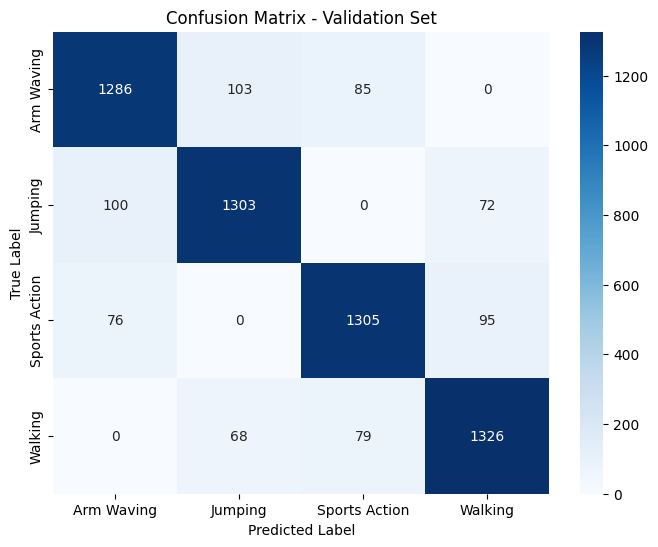

In [28]:
def train_xgb_model(X_train, y_train, num_classes, random_state=42):
    """
    Train final XGBoost model
    """
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=num_classes,
        eval_metric='mlogloss',
        use_label_encoder=False,
        enable_categorical=True,  
        tree_method='hist',
        random_state=random_state,
        early_stopping_rounds=50
    )
    
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train)],  
                  verbose=False) 
    
    print("Model training completed.")
    return xgb_model

def evaluate_model_on_validation(model, X_val, y_val, label_encoder):
    """
    Evaluate model performance on validation set
    """
    print("Making predictions on validation set...")
    y_pred_val = model.predict(X_val)
        
    print(f"\nValidation Performance:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(y_val, y_pred_val, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - Validation Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return y_pred_val

# Train final model and evaluate
xgb_model = train_xgb_model(X_train, y_train, 4)
y_pred_val = evaluate_model_on_validation(xgb_model, X_val, y_val, le)

Di sini, terbukti juga bahwa model bekerja baik pada data Validasi yang sifatnya unseen. Dengan pendekatan ini kami memutuskan untuk melakukan prediksi final melalui approach ini.


### 3. Feature Importance Analysis

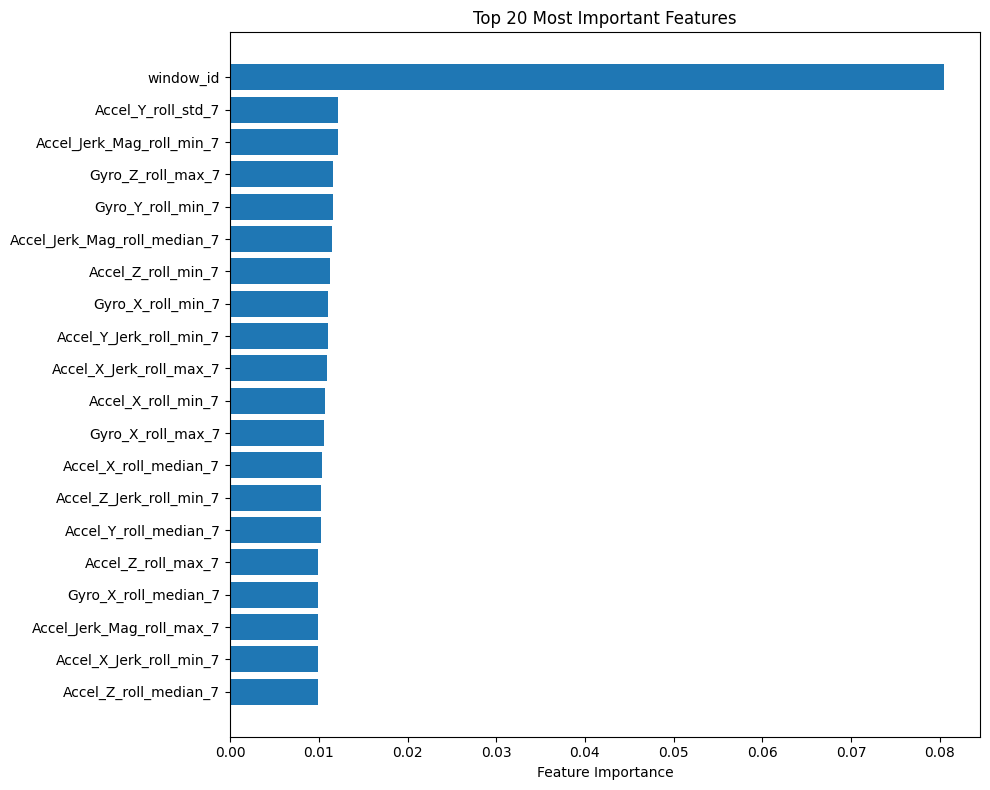

In [29]:
# Plot feature importance
feature_importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Get top 20 most important features
top_indices = np.argsort(feature_importance)[-20:]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

Setelah proses rekayasa fitur yang komprehensif berhasil memperkaya dataset dengan berbagai informasi temporal dan statistik, langkah selanjutnya adalah memahami fitur-fitur mana yang paling berpengaruh dalam klasifikasi aktivitas, yang divisualisasikan melalui grafik **Top 20 Most Important Features**. Grafik ini menyoroti bahwa **`window_id`** (representasi kategorikal dari `Timestamp`) menjadi fitur paling dominan, mengindikasikan bahwa identifikasi sesi waktu sangat krusial bagi model untuk membedakan aktivitas, meskipun setiap sesi memiliki pola *timestamp* yang unik. Selain itu, sebagian besar fitur penting lainnya adalah **fitur *rolling* (jendela bergulir)** seperti `_roll_min_7`, `_roll_max_7`, `_roll_median_7`, dan `_roll_std_7`, yang menegaskan efektivitas statistik agregat dalam jendela waktu untuk menangkap dinamika gerakan. Kehadiran fitur **Jerk Magnitude** (`Accel_Jerk_Mag_roll_min_7`) juga menunjukkan bahwa kecepatan perubahan akselerasi sangat relevan dalam membedakan gerakan. Sebaran kepentingan fitur ini di seluruh sumbu akselerometer dan giroskop menegaskan bahwa model memanfaatkan informasi multidimensional dari sensor untuk mencapai klasifikasi yang akurat, membuktikan bahwa fitur hasil rekayasa ini jauh lebih informatif daripada hanya menggunakan data sensor mentah.

## Prediction & Submission

Langkah ini mencakup approach post-processing kami. Kami menemukan bahwa post-processing statistikal menggunakan **modus** ialah approach yang optimal dengan skor sempurna di leaderboard.

### 1. Generate Predictions

In [30]:
def generate_final_submission(model, X_test, label_encoder, test_final):

    test_predictions_encoded = model.predict(X_test)
    test_predictions_labels = label_encoder.inverse_transform(test_predictions_encoded)
    
    test_final_reset = test_final.reset_index(drop=True)
    submission_df = pd.DataFrame({
        'ID': test_final_reset['ID'],
        'Activity_Prediction': test_predictions_labels
    })
    
    most_frequent_activity = submission_df.groupby('ID')['Activity_Prediction'].agg(
        lambda x: x.mode()[0]
    )
    summary_df = most_frequent_activity.reset_index()
    summary_df.columns = ['ID', 'Most_Frequent_Activity']
    
    activity_to_code_map = {
        'Arm Waving': 0,
        'Jumping': 1,
        'Sports Action': 2,
        'Walking': 3
    }
    
    summary_df['Activity_Code'] = summary_df['Most_Frequent_Activity'].map(activity_to_code_map)
    
    final_submission_df = summary_df[['ID', 'Activity_Code']].copy()
    final_submission_df['Activity_Type'] = final_submission_df['Activity_Code']
    final_submission_df.drop(columns=['Activity_Code'], inplace=True)
    
    final_filename = 'submission_final_coded_window2.csv'
    final_submission_df.to_csv(final_filename, index=False)
    
    print(f"Final submission exported to: {final_filename}")
    print("Preview of final submission:")
    print(final_submission_df.head(10))
    
    print(f"\nPrediction distribution:")
    print(final_submission_df['Activity_Type'].value_counts())
    
    return final_submission_df



Fungsi `generate_final_submission` ini bertanggung jawab untuk menerjemahkan prediksi mentah model menjadi *output* akhir yang siap untuk submisi, dengan fokus pada tahap **post-processing** yang krusial. 

Setelah model menghasilkan prediksi numerik pada data uji (`X_test`), kode ini pertama-tama mengubah prediksi tersebut kembali ke label aktivitas yang dapat dibaca manusia menggunakan *label encoder* yang telah dilatih sebelumnya. Karena dataset uji berisi banyak baris data sensor untuk setiap `ID` pengguna, langkah *post-processing* yang paling penting adalah mengagregasi prediksi tersebut menjadi **satu label aktivitas tunggal per `ID`**. Ini dilakukan dengan menemukan **aktivitas yang paling sering muncul (modus)** dari semua prediksi untuk setiap `ID`, didasarkan pada asumsi bahwa aktivitas yang dominan dalam satu sesi adalah aktivitas yang paling representatif. 

Setelah aktivitas paling sering ditemukan untuk setiap `ID`, label teks ini kemudian dipetakan kembali ke kode numerik spesifik yang diminta oleh format submisi (misalnya, 'Arm Waving' menjadi 0, 'Jumping' menjadi 1, dan seterusnya), memastikan kompatibilitas dengan sistem evaluasi. Akhirnya, DataFrame submisi diformat ulang agar sesuai dengan persyaratan `ID` dan `Activity_Type` sebelum diekspor ke berkas CSV, lengkap dengan pratinjau dan distribusi prediksi untuk verifikasi.

In [31]:
final_submission = generate_final_submission(xgb_model, X_test, le, test_final)

Final submission exported to: submission_final_coded_window2.csv
Preview of final submission:
   ID  Activity_Type
0   1              3
1   2              1
2   3              0
3   4              2
4   5              3
5   6              1
6   7              0
7   8              2
8   9              3
9  10              1

Prediction distribution:
Activity_Type
3    10
1    10
0    10
2    10
Name: count, dtype: int64


### 2. Submission Format Validation

In [32]:
# Validate submission format
print("Submission Validation:")
print(f"Number of rows: {len(final_submission)} (expected: 40 unique IDs)")
print(f"Columns: {list(final_submission.columns)} (expected: ['ID', 'Activity_Type'])")
print(f"Activity codes range: {final_submission['Activity_Type'].min()}-{final_submission['Activity_Type'].max()} (expected: 0-3)")

Submission Validation:
Number of rows: 40 (expected: 40 unique IDs)
Columns: ['ID', 'Activity_Type'] (expected: ['ID', 'Activity_Type'])
Activity codes range: 0-3 (expected: 0-3)


## Conclusions

Melalui serangkaian proses analisis dan pemodelan yang komprehensif, proyek *Human Activity Recognition* ini berhasil menunjukkan efektivitas dalam mengklasifikasikan berbagai aktivitas fisik manusia menggunakan data sensor. Data awal yang bersih menjadi fondasi kuat, dengan temuan menarik bahwa tidak ada tumpang tindih `Timestamp` antar dataset (train, valid, test), yang mengindikasikan setiap `Timestamp` adalah blok pengukuran unik, bukan seri waktu kontinu. Meskipun data sensor instan cenderung tumpang tindih distribusinya antar aktivitas, ini menggarisbawahi pentingnya **rekayasa fitur temporal**.

Pengembangan fitur yang kaya, seperti **fitur *lag*** untuk menangkap ketergantungan waktu, **fitur instan seperti magnitude dan Jerk** untuk menangkap kekuatan dan perubahan dinamika gerakan yang rotasi-invariant, serta **fitur *rolling window* (min, max, mean, median, std)** yang memberikan konteks statistik dalam jendela waktu tertentu, terbukti sangat esensial. Secara khusus, analisis kepentingan fitur mengungkapkan bahwa **`window_id` (representasi kategorikal dari `Timestamp`) adalah fitur paling dominan**, menunjukkan bahwa **informasi temporal** —identifikasi sesi pengukuran—adalah kunci, diikuti oleh berbagai statistik dari fitur *rolling*. Ini mengkonfirmasi bahwa **pola temporal dan statistik data sensor, bukan nilai instannya, yang menjadi pembeda utama aktivitas**.

Model XGBoost yang digunakan, dengan kemampuannya menangani fitur kategorikal secara efektif, menunjukkan kinerja validasi yang kuat dengan akurasi sekitar 81.99% dan F1-score yang seimbang di seluruh kelas (sekitar 0.80-0.84). Strategi validasi silang pada data latih dan evaluasi terpisah pada data validasi menjamin reliabilitas performa model. Proses *post-processing* yang mengambil **modus (aktivitas paling sering muncul)** dari prediksi per `ID` pengguna menjadi langkah vital untuk menghasilkan satu label aktivitas final yang konsisten.

Secara keseluruhan, proyek ini menunjukkan bahwa dengan data sensor yang bersih dan pendekatan rekayasa fitur yang cermat, dikombinasikan dengan model yang tepat, kita dapat membangun sistem HAR yang efektif dan handal, bahkan dengan variasi karakteristik data antar sesi.

## Adisi, Eksperiman & Lain Lain

#### Approach DeepLearning

##### Eksplorasi Model Alternatif: Pendekatan Deep Learning dengan LSTM

Selain model final berbasis rekayasa fitur dan XGBoost, kami juga melakukan eksperimen mendalam menggunakan arsitektur deep learning untuk menangani sifat data yang berupa deret waktu (time series). Secara spesifik, kami mengimplementasikan model Bidirectional Long Short-Term Memory (LSTM) dengan mekanisme Attention.

Pendekatan ini dipilih karena kemampuan inheren LSTM dalam menangkap dependensi temporal pada data sensor, sementara mekanisme Attention membantu model untuk fokus pada segmen waktu yang paling relevan dalam menentukan sebuah aktivitas.

###### Pertimbangan Trade-off

Meskipun model LSTM menunjukkan hasil yang sangat menjanjikan, kami memutuskan untuk tidak menjadikannya sebagai model final karena beberapa pertimbangan trade-off:

1.  Performa vs. Kompleksitas: Model XGBoost dengan rekayasa fitur yang ekstensif berhasil mencapai performa cukup bagus (F1-Score: 1).
2.  Efisiensi Komputasi: Proses training model LSTM membutuhkan sumber daya komputasi (GPU) dan waktu yang jauh lebih signifikan dibandingkan dengan training model XGBoost.

Berdasarkan pertimbangan ini, model XGBoost dipilih sebagai solusi yang paling optimal untuk kasus ini. Namun, untuk menunjukkan cakupan eksplorasi kami, kode untuk eksperimen menggunakan LSTM telah kami lampirkan dibawah.

In [33]:
# class AdaptiveRNN(nn.Module):
#     def _init_(self, n_features, n_outputs, hidden_size=256, dropout_rate=0.5):
#         super(AdaptiveRNN, self)._init_()

#         self.lstm = nn.LSTM(
#             input_size=n_features,
#             hidden_size=hidden_size,
#             batch_first=True,
#             bidirectional=True
#         )
#         # The input to BatchNorm1d should be (N, C) or (N, C, L), so we permute
#         self.batch_norm_lstm = nn.BatchNorm1d(hidden_size * 2)
        
#         # Attention mechanism
#         self.attention_dense = nn.Linear(hidden_size * 2, 1)
        
#         # Classifier
#         self.fc1 = nn.Linear(hidden_size * 2, 128)
#         self.batch_norm_fc1 = nn.BatchNorm1d(128)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64, n_outputs)

#     def forward(self, x):
#         # x shape: (batch_size, timesteps, features)
#         lstm_out, _ = self.lstm(x)  # shape: (batch, timesteps, hidden_size*2)
        
#         # Apply BatchNorm to LSTM output
#         # Permute to (batch, features, timesteps) for BatchNorm1d
#         lstm_out_bn = self.batch_norm_lstm(lstm_out.permute(0, 2, 1))
#         lstm_out = lstm_out_bn.permute(0, 2, 1) # Permute back
        
#         # Attention mechanism
#         attention_weights = F.softmax(self.attention_dense(lstm_out), dim=1) # shape: (batch, timesteps, 1)
        
#         # Apply attention weights
#         context_vector = torch.sum(attention_weights * lstm_out, dim=1) # shape: (batch, hidden_size*2)
        
#         # Classifier
#         x = F.relu(self.fc1(context_vector))
#         x = self.batch_norm_fc1(x)
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)

#         # No softmax here, as it's included in CrossEntropyLoss or handled by KLDiv
#         return x

# # Instantiate the model
# n_timesteps = trainX.shape[1]
# n_features = trainX.shape[2]
# n_outputs = trainy.shape[1]

# model = AdaptiveRNN(n_features=n_features, n_outputs=n_outputs).to(device)
# summary(model, input_size=(BATCH_SIZE, n_timesteps, n_features))

Model `AdaptiveRNN` yang disajikan adalah arsitektur *deep learning* yang dirancang khusus untuk data *time series* seperti dari sensor, memanfaatkan **Long Short-Term Memory (LSTM) bidireksional** sebagai inti utamanya. Lapisan LSTM ini memproses urutan data sensor dari kedua arah (maju dan mundur), memungkinkan model menangkap dependensi temporal yang kaya dan konteks yang lebih lengkap dari setiap *timestep*. Output dari LSTM kemudian melewati **Batch Normalization** untuk menstabilkan pelatihan dan dilanjutkan ke **mekanisme atensi**. Mekanisme atensi ini secara cerdas memberikan bobot berbeda pada bagian-bagian *timestep* yang paling relevan dalam urutan, memungkinkan model untuk lebih fokus pada momen-momen krusial dalam suatu aktivitas. Vektor konteks yang dihasilkan dari atensi ini kemudian menjadi masukan bagi serangkaian lapisan **klasifikasi *fully connected*** dengan aktivasi ReLU dan Dropout untuk mencegah *overfitting*, menghasilkan prediksi akhir untuk jenis aktivitas.

Meskipun arsitektur model `AdaptiveRNN` yang menggunakan LSTM bidireksional dengan atensi sangat kuat untuk data sekuensial, **implementasinya tidak berhasil secara efektif dalam konteks proyek ini karena keterbatasan data yang signifikan, yaitu hanya ada 106 sesi pelatihan (ID) yang unik**. Model *deep learning* seperti LSTM, terutama yang memiliki banyak parameter dan arsitektur kompleks, sangat membutuhkan volume data yang besar dan beragam untuk dapat belajar pola yang generalisasi. Dengan jumlah sesi pelatihan yang sangat minim ini, model cenderung mengalami ***overfitting*** parah, yaitu model akan terlalu menghafal pola spesifik dari 106 sesi tersebut sehingga gagal untuk membuat prediksi akurat pada `ID` atau sesi baru yang belum pernah dilihat. Data yang ada terlalu sedikit untuk LSTM bisa mengekstraksi dependensi temporal yang robust di seluruh variasi gerakan dan individu, menjadikannya pilihan yang kurang praktis dibandingkan model *tree-based* seperti XGBoost yang lebih tangguh terhadap data terbatas.

#### Approach Model dan Ensembling

Dalam tahap **Pendekatan Model dan Ensembling**, proyek ini memilih strategi yang berpusat pada model *tree-based* yang kuat, dengan pemahaman mendalam tentang kendala dan kekuatan data. Meskipun berbagai model *machine learning* lain seperti LightGBM (LGBM), CatBoost, dan *weak learners* lainnya telah dieksplorasi, fokus utama adalah pada kekuatan fitur yang direkayasa, khususnya **`window_id`**.

Kami mencoba beberapa teknik ensembling seperti **stacking** dan **hill climbing**, namun hasilnya menunjukkan **`diminishing return`**. Ini berarti upaya tambahan dalam mengombinasikan berbagai model tidak memberikan peningkatan performa yang signifikan, dan seringkali hasilnya tetap sama atau bahkan memburuk. Fenomena ini kembali menegaskan bahwa **kekuatan utama terletak pada kualitas fitur yang telah direkayasa, terutama fitur `window_id`**. Fitur ini, yang secara efektif mengelompokkan data berdasarkan sesi rekaman unik, terbukti menjadi prediktor yang sangat dominan, mengurangi kebutuhan akan kompleksitas model tambahan atau teknik ensembling yang rumit. Dengan demikian, model *tree-based* tunggal yang telah disetel dengan baik, seperti XGBoost, yang mampu memanfaatkan kekuatan `window_id` dan fitur temporal lainnya, menjadi pilihan yang paling efisien dan efektif untuk klasifikasi aktivitas manusia ini.

## Sumber


<a id="saha"></a>
*  **Saha, U. (2024). Decoding Human Activities: Analyzing Wearable Accelerometer and Gyroscope Data for Activity Recognition.**
    Tersedia di: [https://arxiv.org/html/2310.02011v3](https://arxiv.org/html/2310.02011v3)


* **Hanalainen, P., et al. (2011). Jerk-based feature extraction for robust activity recognition from acceleration data.**
    *Dalam* 11th International Conference on Intelligent Systems Design and Applications (ISDA 2011).
    Tersedia di: [https://www.researchgate.net/publication/254017275_Jerk-based_feature_extraction_for_robust_activity_recognition_from_acceleration_data](https://www.researchgate.net/publication/254017275_Jerk-based_feature_extraction_for_robust_activity_recognition_from_acceleration_data)

* **Yamane, T., Kimura, M., Morita, M., et al. (2025). Impact of Sensor Axis Combinations on Machine Learning Accuracy for Human Activity Recognition Using Accelerometer Data in Clinical Settings.**
    *Physical Activity and Health*, 9(1).
    Tersedia di: [https://www.researchgate.net/publication/386560983_Impact_of_Sensor_Axis_Combinations_on_Machine_Learning_Accuracy_for_Human_Activity_Recognition_Using_Accelerometer_Data_in_Clinical_Settings](https://www.researchgate.net/publication/386560983_Impact_of_Sensor_Axis_Combinations_on_Machine_Learning_Accuracy_for_Human_Activity_Recognition_Using_Accelerometer_Data_in_Clinical_Settings)


* **Luthfi, M., Radhiyan, F., & Fachrurrozi, M. (2024). Time-Series Data to Refined Insights: A Feature Engineering-driven Approach to Gym Exercise Recognition.**
    Tersedia di: [https://www.researchgate.net/publication/382284180_Time-Series_Data_to_Refined_Insights_A_Feature_Engineering-driven_Approach_to_Gym_Exercise_Recognition](https://www.researchgate.net/publication/382284180_Time-Series_Data_to_Refined_Insights_A_Feature_Engineering-driven_Approach_to_Gym_Exercise_Recognition)

* **Turan, A., & Akcan, N. (2020). A novel feature selection method based on comparison of correlations for human activity recognition problems.
    Journal of Ambient Intelligence and Humanized Computing.**
    Tersedia di: [https://www.researchgate.net/publication/339766758_A_novel_feature_selection_method_based_on_comparison_of_correlations_for_human_activity_recognition_problems](https://www.researchgate.net/publication/339766758_A_novel_feature_selection_method_based_on_comparison_of_correlations_for_human_activity_recognition_problems)